In [187]:
import joblib
import warnings
import inflection

import numpy             as np
import pandas            as pd
import seaborn           as sns

import matplotlib.pyplot as plt

from scipy   import stats
from boruta  import BorutaPy
from category_encoders import OneHotEncoder

from IPython.display      import Image
from IPython.core.display import HTML 

from xgboost  import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm          import SVC
from sklearn.dummy        import DummyClassifier
from sklearn.ensemble     import RandomForestClassifier
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics         import balanced_accuracy_score, precision_score, classification_report
from sklearn.metrics         import recall_score, f1_score, make_scorer, cohen_kappa_score
from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold

In [1]:
pip install -r requirements.txt

     ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
     ----------------------- ---------------- 1.0/1.8 MB 34.5 MB/s eta 0:00:01
     ---------------------------------------- 1.8/1.8 MB 4.3 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [39 lines of output]
      Traceback (most recent call last):
        File "c:\Users\artit\OneDrive - IKNOWPLUS COMPANY LIMITED\Documents\fraud\fruad_cs\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 389, in <module>
          main()
          ~~~~^^
        File "c:\Users\artit\OneDrive - IKNOWPLUS COMPANY LIMITED\Documents\fraud\fruad_cs\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 373, in main
          json_out["return_val"] = hook(**hook_input["kwargs"])
                                   ~~~~^^^^^^^^^^^^^^^^^^^^^^^^
        File "c:\Users\artit\OneDrive - IKNOWPLUS COMPANY LIMITED\Documents\fraud\fruad_cs\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 143, in get_requires_for_build_wheel
          return hook(config_settings)
        File "C:\Users\arti

#### 0.2 Helper Functions

In [189]:
warnings.filterwarnings('ignore')

seed = 42
np.random.seed(seed)

In [190]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    sns.set(font_scale=1.6)
    
    sns.set_style('darkgrid')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 16
    
    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [191]:
def ml_scores(model_name, y_true, y_pred):
    
    accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    
    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 3), 
                         'Precision': np.round(precision, 3), 
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3),
                         'Kappa': np.round(kappa, 3)}, 
                        index=[model_name])

In [192]:
def calcCramerV(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [193]:
def ml_cv_results(model_name, model, x, y, verbose=1):
    
    '''initial'''
    balanced_accuracies = []
    precisions = []
    recalls = []
    f1s = []
    kappas = []
    
    mm = MinMaxScaler()
    
    x_ = x.to_numpy()
    y_ = y.to_numpy()
    
    count = 0
    
    '''cross-validation'''
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    
    for index_train, index_test in skf.split(x_, y_):
        ## Showing the Fold
        if verbose > 0:
            count += 1
            print('Fold K=%i' % (count))
    
        ## selecting train and test
        x_train, x_test = x.iloc[index_train], x.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]
        
        ## applying the scale
        x_train = mm.fit_transform(x_train)
        x_test = mm.transform(x_test)
    
        ## training the model
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        ## saving the metrics
        balanced_accuracies.append(balanced_accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        kappas.append(cohen_kappa_score(y_test, y_pred))
        
        
    '''results'''    
    accuracy_mean, accuracy_std = np.round(np.mean(balanced_accuracies), 3), np.round(np.std(balanced_accuracies), 3)
    precision_mean, precision_std = np.round(np.mean(precisions), 3), np.round(np.std(precisions), 3)
    recall_mean, recall_std = np.round(np.mean(recalls), 3), np.round(np.std(recalls), 3)
    f1_mean, f1_std = np.round(np.mean(f1s), 3), np.round(np.std(f1s), 3)
    kappa_mean, kappa_std = np.round(np.mean(kappas), 3), np.round(np.std(kappas), 3)
    
    ## saving the results in a dataframe
    return pd.DataFrame({"Balanced Accuracy": "{} +/- {}".format(accuracy_mean, accuracy_std),
                        "Precision": "{} +/- {}".format(precision_mean, precision_std),
                        "Recall": "{} +/- {}".format(recall_mean, recall_std),
                        "F1": "{} +/- {}".format(f1_mean, f1_std),
                        "Kappa": "{} +/- {}".format(kappa_mean, kappa_std)},
                       index=[model_name])

### 1.0 Data Description

#### 1.1 Loading Data

In [194]:
df1 = pd.read_csv('C:/Users/artit/Downloads/fraud_0.1origbase.csv')

In [195]:
df1.head(100)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,283,CASH_IN,210329.84,C1159819632,3778062.79,3988392.64,C1218876138,1519266.60,1308936.76,0,0
1,132,CASH_OUT,215489.19,C1372369468,21518.00,0.00,C467105520,6345756.55,6794954.89,0,0
2,355,DEBIT,4431.05,C1059822709,20674.00,16242.95,C76588246,80876.56,85307.61,0,0
3,135,CASH_OUT,214026.20,C1464960643,46909.73,0.00,C1059379810,13467450.36,13681476.56,0,0
4,381,CASH_OUT,8858.45,C831134427,0.00,0.00,C579876929,1667180.58,1676039.03,0,0
5,208,CASH_IN,256440.86,C1001269496,554.00,256994.86,C1503528288,0.00,0.00,0,0
6,347,CASH_OUT,120989.98,C803141068,0.00,0.00,C1951883397,6963396.37,7084386.35,0,0
7,183,CASH_OUT,62655.01,C309960888,18997.00,0.00,C1715810305,130706.17,193361.18,0,0
8,184,CASH_OUT,256745.11,C1447987365,0.00,0.00,C1629212528,1475890.41,1732635.52,0,0
9,12,PAYMENT,13693.22,C243045039,9040.00,0.00,M55115072,0.00,0.00,0,0


In [196]:
df1.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
636257,351,CASH_OUT,28761.10,C742050657,0.0,0.00,C568407561,328534.52,357295.62,0,0
636258,184,CASH_OUT,167820.71,C561181412,62265.0,0.00,C1852953580,106429.48,274250.18,0,0
636259,35,PAYMENT,8898.12,C1773417333,30808.0,21909.88,M445701551,0.00,0.00,0,0
636260,277,CASH_OUT,176147.90,C1423233247,83669.0,0.00,C1328739120,0.00,176147.90,0,0
636261,304,CASH_OUT,95142.89,C874575079,0.0,0.00,C666451134,431380.07,526522.96,0,0


### 1.2 Columns
#### 1.2.1 Column Descriptions
step: maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount: amount of the transaction in local currency.

nameOrig: customer who started the transaction

oldbalanceOrg: initial balance before the transaction

newbalanceOrig: new balance after the transaction

nameDest: customer who is the recipient of the transaction

oldbalanceDest: initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest: new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud: This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud: The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

#### 1.2.2 Column Rename

In [197]:
cols_old = df1.columns.tolist()

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

In [198]:
df1.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud'],
      dtype='object')

### 1.3 Data Dimension

In [199]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 636262
Number of Cols: 11


### 1.4 Data Types and Structure

In [200]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636262 entries, 0 to 636261
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   step              636262 non-null  int64  
 1   type              636262 non-null  object 
 2   amount            636262 non-null  float64
 3   name_orig         636262 non-null  object 
 4   oldbalance_org    636262 non-null  float64
 5   newbalance_orig   636262 non-null  float64
 6   name_dest         636262 non-null  object 
 7   oldbalance_dest   636262 non-null  float64
 8   newbalance_dest   636262 non-null  float64
 9   is_fraud          636262 non-null  int64  
 10  is_flagged_fraud  636262 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 53.4+ MB


### 1.5 Check NA

In [201]:
df1.isna().mean()

step                0.0
type                0.0
amount              0.0
name_orig           0.0
oldbalance_org      0.0
newbalance_orig     0.0
name_dest           0.0
oldbalance_dest     0.0
newbalance_dest     0.0
is_fraud            0.0
is_flagged_fraud    0.0
dtype: float64

### 1.6 Fill Out NA
There's no NaN values to fill.

### 1.7 Change Data Type
I will change the values 0 and 1 to 'yes' and 'no'. It'll help on the data description and analysis sections.

In [202]:
df1['is_fraud'] = df1['is_fraud'].map({1: 'yes', 0: 'no'})
df1['is_flagged_fraud'] = df1['is_flagged_fraud'].map({1: 'yes', 0: 'no'})

In [203]:
df1.head()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
0,283,CASH_IN,210329.84,C1159819632,3778062.79,3988392.64,C1218876138,1519266.60,1308936.76,no,no
1,132,CASH_OUT,215489.19,C1372369468,21518.00,0.00,C467105520,6345756.55,6794954.89,no,no
2,355,DEBIT,4431.05,C1059822709,20674.00,16242.95,C76588246,80876.56,85307.61,no,no
3,135,CASH_OUT,214026.20,C1464960643,46909.73,0.00,C1059379810,13467450.36,13681476.56,no,no
4,381,CASH_OUT,8858.45,C831134427,0.00,0.00,C579876929,1667180.58,1676039.03,no,no


### 1.8 Description Statistics

In [204]:
num_attributes = df1.select_dtypes(exclude='object')
cat_attributes = df1.select_dtypes(include='object')

#### 1.8.1 Numerical Attributes

In [205]:
describe = num_attributes.describe().T

describe['range'] = (num_attributes.max() - num_attributes.min()).tolist()
describe['variation coefficient'] = (num_attributes.std() / num_attributes.mean()).tolist()
describe['skew'] = num_attributes.skew().tolist()
describe['kurtosis'] = num_attributes.kurtosis().tolist()

describe

,count,mean,std,min,25%,50%,75%,max,range,variation coefficient,skew,kurtosis
step,636262.0,2.429319e+02,1.423309e+02,1.0,155.000,238.000,3.340000e+02,7.420000e+02,7.410000e+02,0.585888,0.375052,0.324437
amount,636262.0,1.800585e+05,6.069714e+05,0.0,13407.425,74815.770,2.084988e+05,5.722962e+07,5.722962e+07,3.370967,29.577107,1546.661043
oldbalance_org,636262.0,8.317937e+05,2.885636e+06,0.0,0.000,14239.000,1.072998e+05,4.368662e+07,4.368662e+07,3.469173,5.243428,32.766036
newbalance_orig,636262.0,8.528354e+05,2.921296e+06,0.0,0.000,0.000,1.435652e+05,4.367380e+07,4.367380e+07,3.425393,5.173614,31.932547
oldbalance_dest,636262.0,1.096212e+06,3.375389e+06,0.0,0.000,131539.745,9.384820e+05,3.551855e+08,3.551855e+08,3.079138,20.622388,1074.335293
newbalance_dest,636262.0,1.221809e+06,3.656213e+06,0.0,0.000,214712.725,1.109230e+06,3.555534e+08,3.555534e+08,2.992460,19.623903,928.694204



- All the data has a coeficient of variation greater than 25%, therefore they aren't homogeneous.

- The step variable starts from 1 hour to 742 hour (30 days).

- Some variables are higher shap and right skewed.

- 50% of the newbalance_orig is 0. Maybe there are some transfers that don't go to the destination.

- The skew is higher positive, therefore the values may be in less values.

#### 1.8.2 Categorical Attributes

In [206]:
cat_attributes.describe()

,type,name_orig,name_dest,is_fraud,is_flagged_fraud
count,636262,636262,636262,636262,636262
unique,5,636171,457224,2,2
top,CASH_OUT,C1785652992,C1023714065,no,no
freq,224216,2,14,635441,636260


In [207]:
df2 = df1.copy()
df2.head()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
0,283,CASH_IN,210329.84,C1159819632,3778062.79,3988392.64,C1218876138,1519266.60,1308936.76,no,no
1,132,CASH_OUT,215489.19,C1372369468,21518.00,0.00,C467105520,6345756.55,6794954.89,no,no
2,355,DEBIT,4431.05,C1059822709,20674.00,16242.95,C76588246,80876.56,85307.61,no,no
3,135,CASH_OUT,214026.20,C1464960643,46909.73,0.00,C1059379810,13467450.36,13681476.56,no,no
4,381,CASH_OUT,8858.45,C831134427,0.00,0.00,C579876929,1667180.58,1676039.03,no,no


### 2.1 Mind Map

In [208]:
#Image('../images/Fraud-mindmap.png')

### 2.2 Hypothesis Creation
#### 2.2.1 User
90% of the twentyone-year-old users did a fraud transiction.

The majority fraud transiction occours for the same initial letter user.

The fraud amount is greater than 10.000.

The 60% of the age is greater than 30 year old.

#### 2.2.2 Type
60% of fraud transaction occours using cash-out-type method.

The majority transfers occours using tranfers-type method.

Values greater than 100.000 occours using transfers-type method.

Payment type occurs with values lower than 100.000

#### 2.2.3 Origin and Destiny Transactions
60% of the difference between origin destiny transactions is equal 0 for frauds.

Origin values are greater than destiny values for fraud transaction.

#### 2.2.4 Time
Fraud transactions occours at least in 3 days.

40% of the cash-out transactions occours less than 1 day.

60% of the transaction less than 100.000 occours at least 10 days.

The transactions greater than 10.000 occours at most in 2 weeks.

### 2.3 Hipothesys List
The majority fraud transiction occours for the same initial letter user.

All the fraud amount is greater than 10.000.

60% of fraud transaction occours using cash-out-type method.

The majority transfers occours using tranfers-type method.

Fraud transactions occours at least in 3 days.

### 2.4 Feature Engineering

In [209]:
# step
df2['step_days'] = df2['step'].apply(lambda i: i/24)
df2['step_weeks'] = df2['step'].apply(lambda i: i/(24*7))

# difference between initial balance before the transaction and new balance after the transaction
df2['diff_new_old_balance'] = df2['newbalance_orig'] - df2['oldbalance_org']

# difference between initial balance recipient before the transaction and new balance recipient after the transaction.
df2['diff_new_old_destiny'] = df2['newbalance_dest'] - df2['oldbalance_dest']

# name orig and name dest
df2['name_orig'] = df2['name_orig'].apply(lambda i: i[0])
df2['name_dest'] = df2['name_dest'].apply(lambda i: i[0])

## 3.0 Selecting Columns

In [210]:
df3 = df2.copy()
df3.head(10)

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,step_days,step_weeks,diff_new_old_balance,diff_new_old_destiny
0,283,CASH_IN,210329.84,C,3778062.79,3988392.64,C,1519266.60,1308936.76,no,no,11.791667,1.684524,210329.85,-210329.84
1,132,CASH_OUT,215489.19,C,21518.00,0.00,C,6345756.55,6794954.89,no,no,5.500000,0.785714,-21518.00,449198.34
2,355,DEBIT,4431.05,C,20674.00,16242.95,C,80876.56,85307.61,no,no,14.791667,2.113095,-4431.05,4431.05
3,135,CASH_OUT,214026.20,C,46909.73,0.00,C,13467450.36,13681476.56,no,no,5.625000,0.803571,-46909.73,214026.20
4,381,CASH_OUT,8858.45,C,0.00,0.00,C,1667180.58,1676039.03,no,no,15.875000,2.267857,0.00,8858.45
5,208,CASH_IN,256440.86,C,554.00,256994.86,C,0.00,0.00,no,no,8.666667,1.238095,256440.86,0.00
6,347,CASH_OUT,120989.98,C,0.00,0.00,C,6963396.37,7084386.35,no,no,14.458333,2.065476,0.00,120989.98
7,183,CASH_OUT,62655.01,C,18997.00,0.00,C,130706.17,193361.18,no,no,7.625000,1.089286,-18997.00,62655.01
8,184,CASH_OUT,256745.11,C,0.00,0.00,C,1475890.41,1732635.52,no,no,7.666667,1.095238,0.00,256745.11
9,12,PAYMENT,13693.22,C,9040.00,0.00,M,0.00,0.00,no,no,0.500000,0.071429,-9040.00,0.00


### 3.1 Selecting Columns
I'll use all the columns for data analysis

### 3.2 Selecting Lines
I'll use all the lines.

## 4.0 Exploratory Data Analisys

In [211]:
df4 = df3.copy()
df4.head(10)

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,step_days,step_weeks,diff_new_old_balance,diff_new_old_destiny
0,283,CASH_IN,210329.84,C,3778062.79,3988392.64,C,1519266.60,1308936.76,no,no,11.791667,1.684524,210329.85,-210329.84
1,132,CASH_OUT,215489.19,C,21518.00,0.00,C,6345756.55,6794954.89,no,no,5.500000,0.785714,-21518.00,449198.34
2,355,DEBIT,4431.05,C,20674.00,16242.95,C,80876.56,85307.61,no,no,14.791667,2.113095,-4431.05,4431.05
3,135,CASH_OUT,214026.20,C,46909.73,0.00,C,13467450.36,13681476.56,no,no,5.625000,0.803571,-46909.73,214026.20
4,381,CASH_OUT,8858.45,C,0.00,0.00,C,1667180.58,1676039.03,no,no,15.875000,2.267857,0.00,8858.45
5,208,CASH_IN,256440.86,C,554.00,256994.86,C,0.00,0.00,no,no,8.666667,1.238095,256440.86,0.00
6,347,CASH_OUT,120989.98,C,0.00,0.00,C,6963396.37,7084386.35,no,no,14.458333,2.065476,0.00,120989.98
7,183,CASH_OUT,62655.01,C,18997.00,0.00,C,130706.17,193361.18,no,no,7.625000,1.089286,-18997.00,62655.01
8,184,CASH_OUT,256745.11,C,0.00,0.00,C,1475890.41,1732635.52,no,no,7.666667,1.095238,0.00,256745.11
9,12,PAYMENT,13693.22,C,9040.00,0.00,M,0.00,0.00,no,no,0.500000,0.071429,-9040.00,0.00


### 4.1 Univariate Analysis
#### 4.1.1 Response Variable

In [212]:
total = df4['is_fraud'].size
total

636262

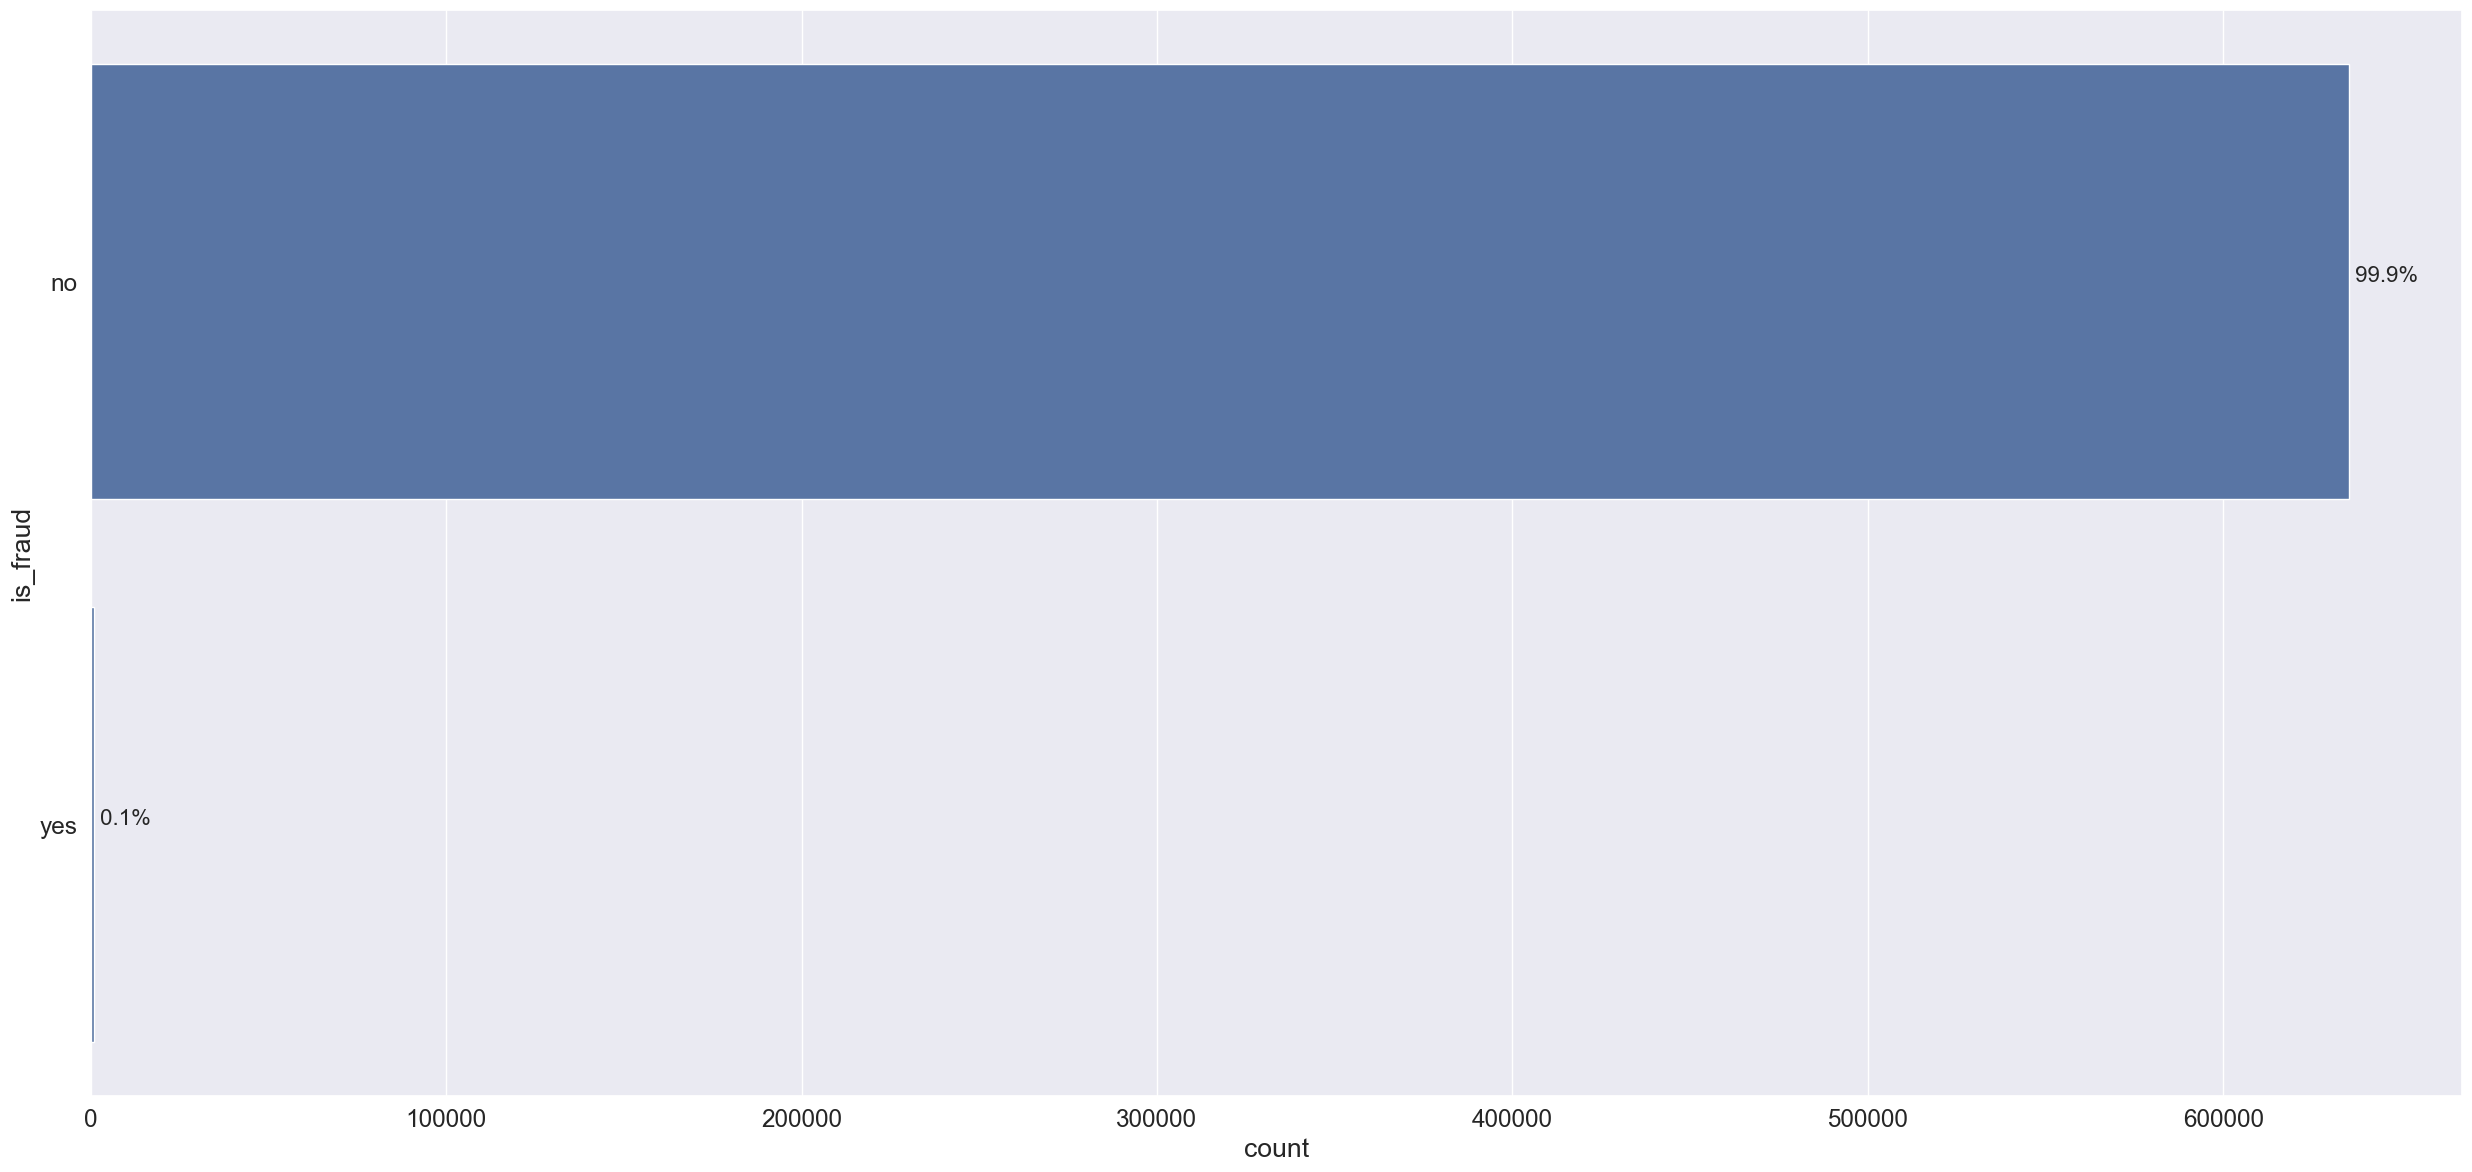

In [213]:
ax = sns.countplot(y='is_fraud', data=df4);

total = df4['is_fraud'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.tight_layout()
plt.show()

### 4.1.2 Numerical Variables

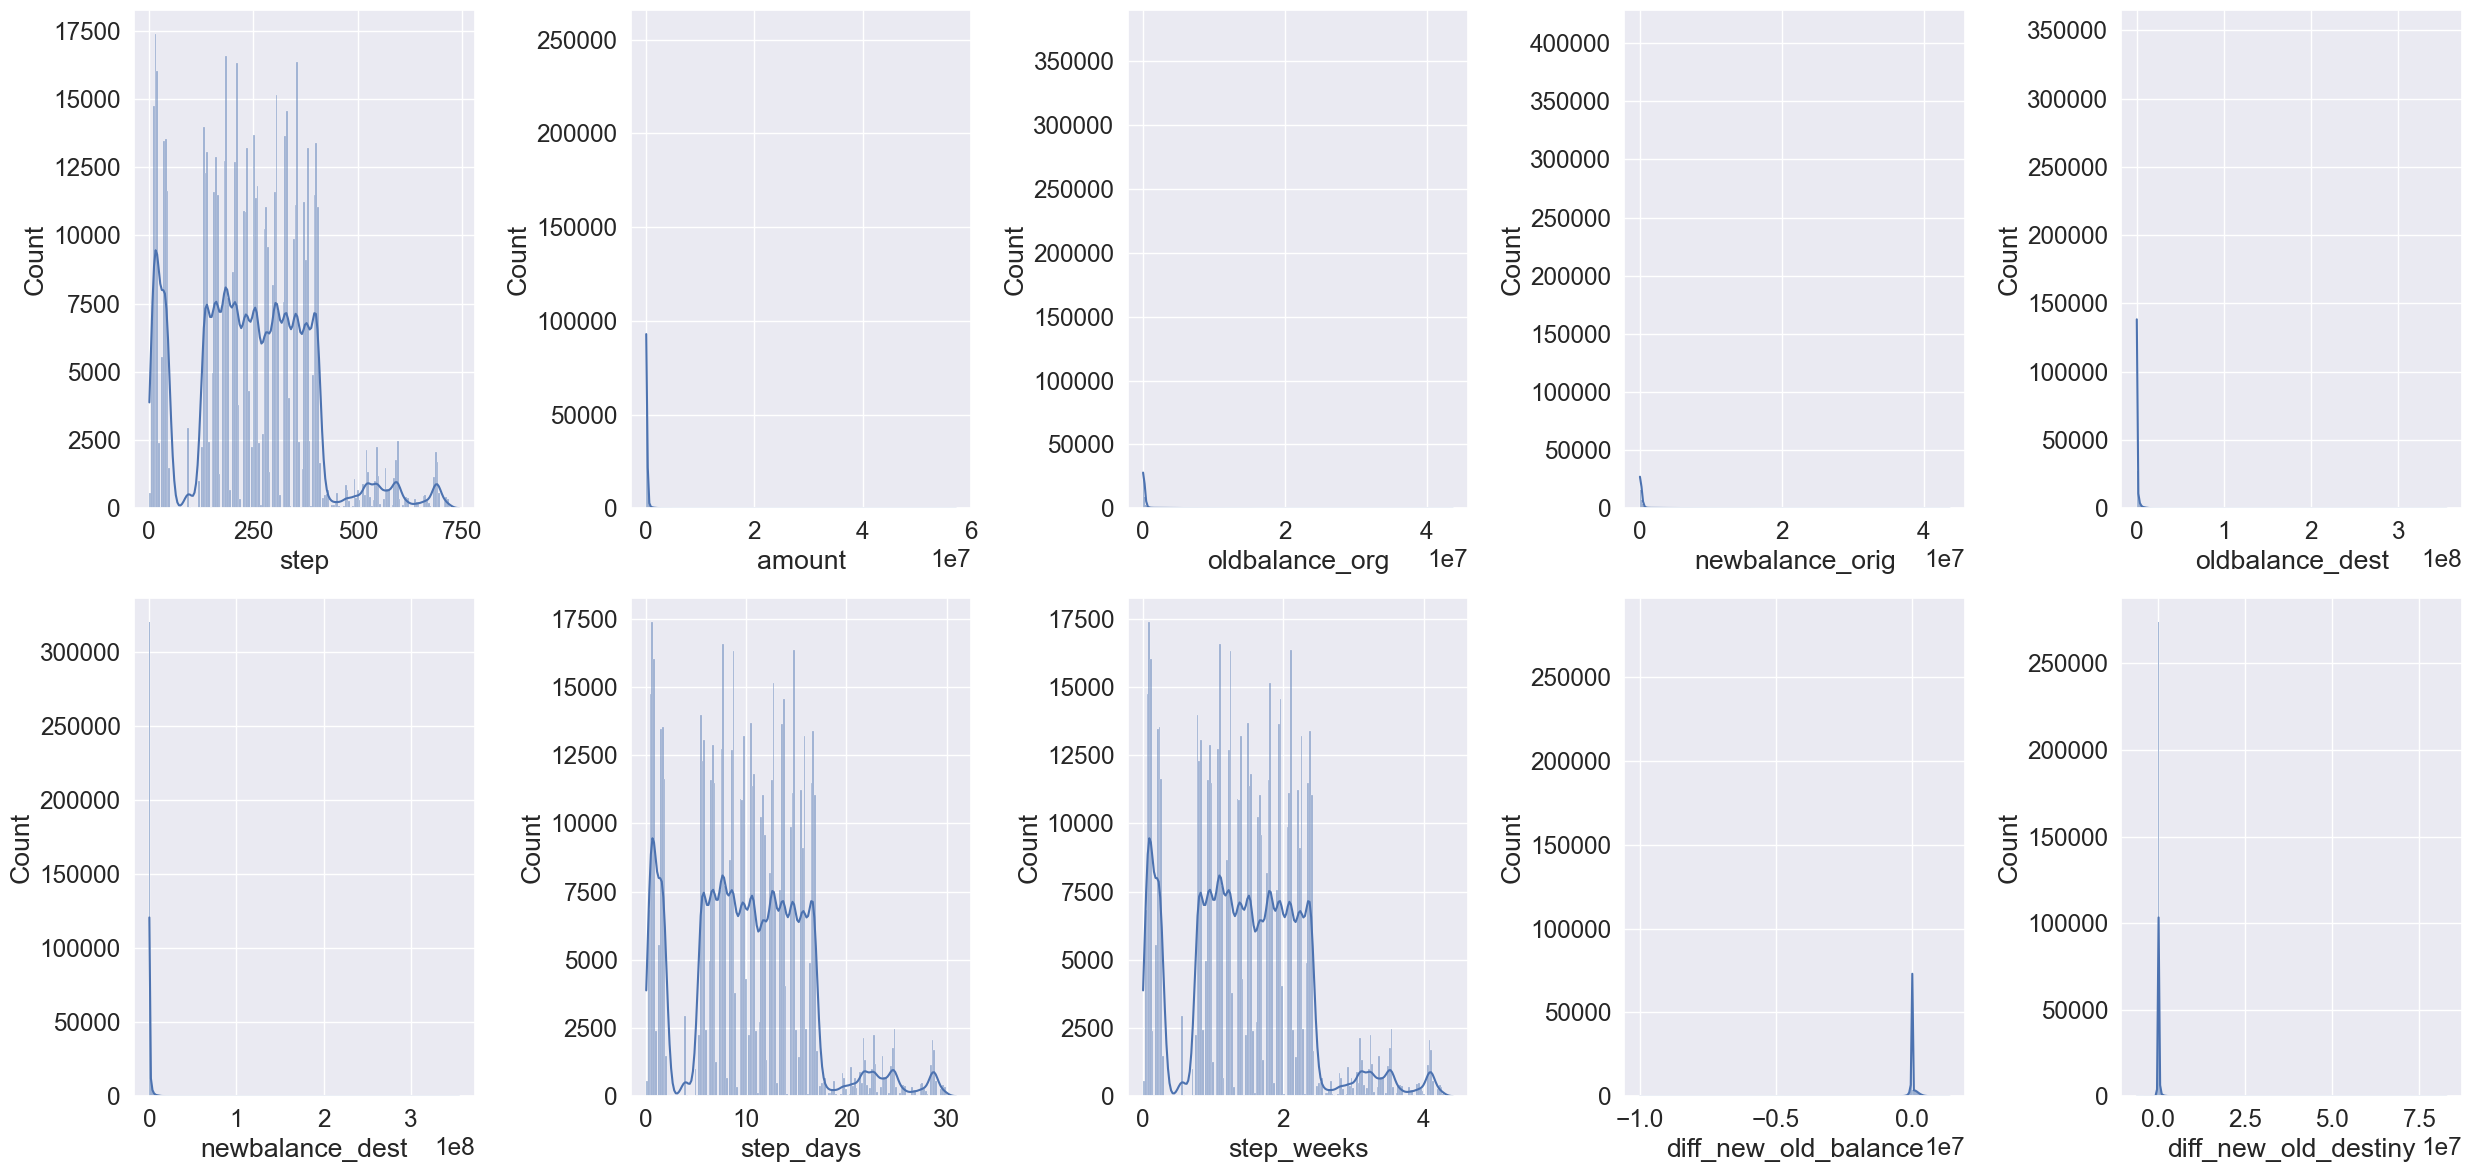

In [214]:
num_attributes = df4.select_dtypes(exclude='object')
columns = num_attributes.columns.tolist()
j = 1

for column in columns:
    plt.subplot(2, 5, j)
    sns.histplot(num_attributes[column], kde=True);
    
    j += 1

plt.tight_layout()  # จัดระยะให้สวยงาม
plt.show()

### 4.1.3 Categorical Variables

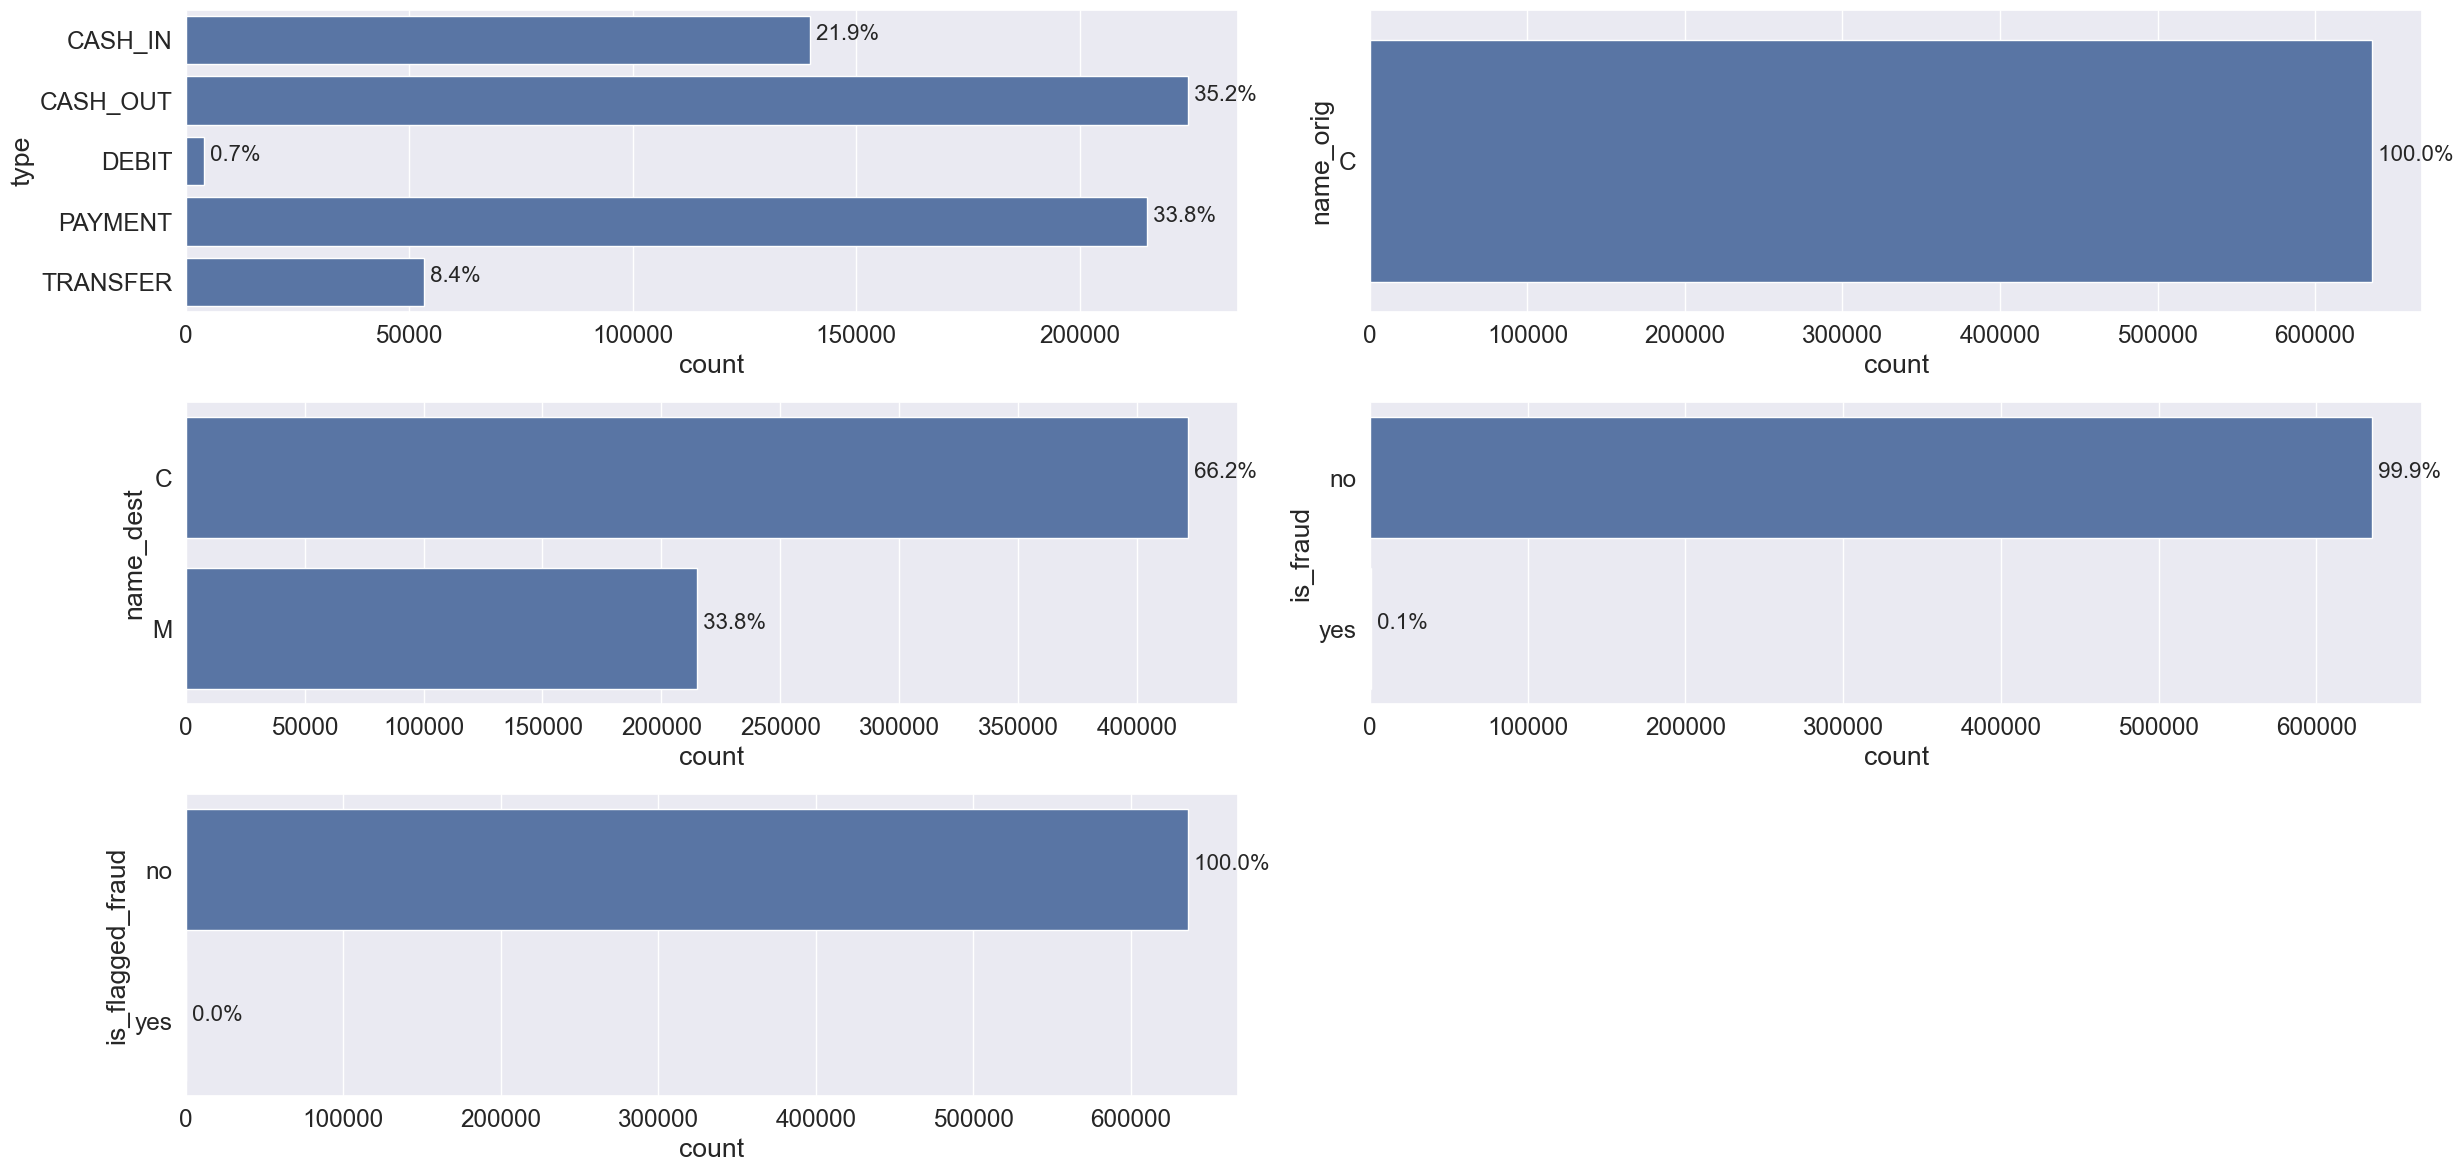

In [215]:
cat_attributes = df4.select_dtypes(include='object')
columns = cat_attributes.columns.tolist()
j = 1

for column in columns:
    plt.subplot(3, 2, j)
    ax = sns.countplot(y=column, data=cat_attributes)
    
    total = cat_attributes[column].size
    for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
    
    j += 1


plt.tight_layout()  # จัดระยะให้สวยงาม
plt.show()

In [216]:
df4.select_dtypes(include='object').head()

,type,name_orig,name_dest,is_fraud,is_flagged_fraud
0,CASH_IN,C,C,no,no
1,CASH_OUT,C,C,no,no
2,DEBIT,C,C,no,no
3,CASH_OUT,C,C,no,no
4,CASH_OUT,C,C,no,no


## 4.2 Bivariate Analysis
H1 The majority fraud transiction occours for the same user.

**TRUE**: The same user origem and destiny has got the same inital letter.

-- Fraud Transaction ชื่อผู้ใช้ต้นทางและปลายทางมี ตัวอักษรแรกเหมือนกัน


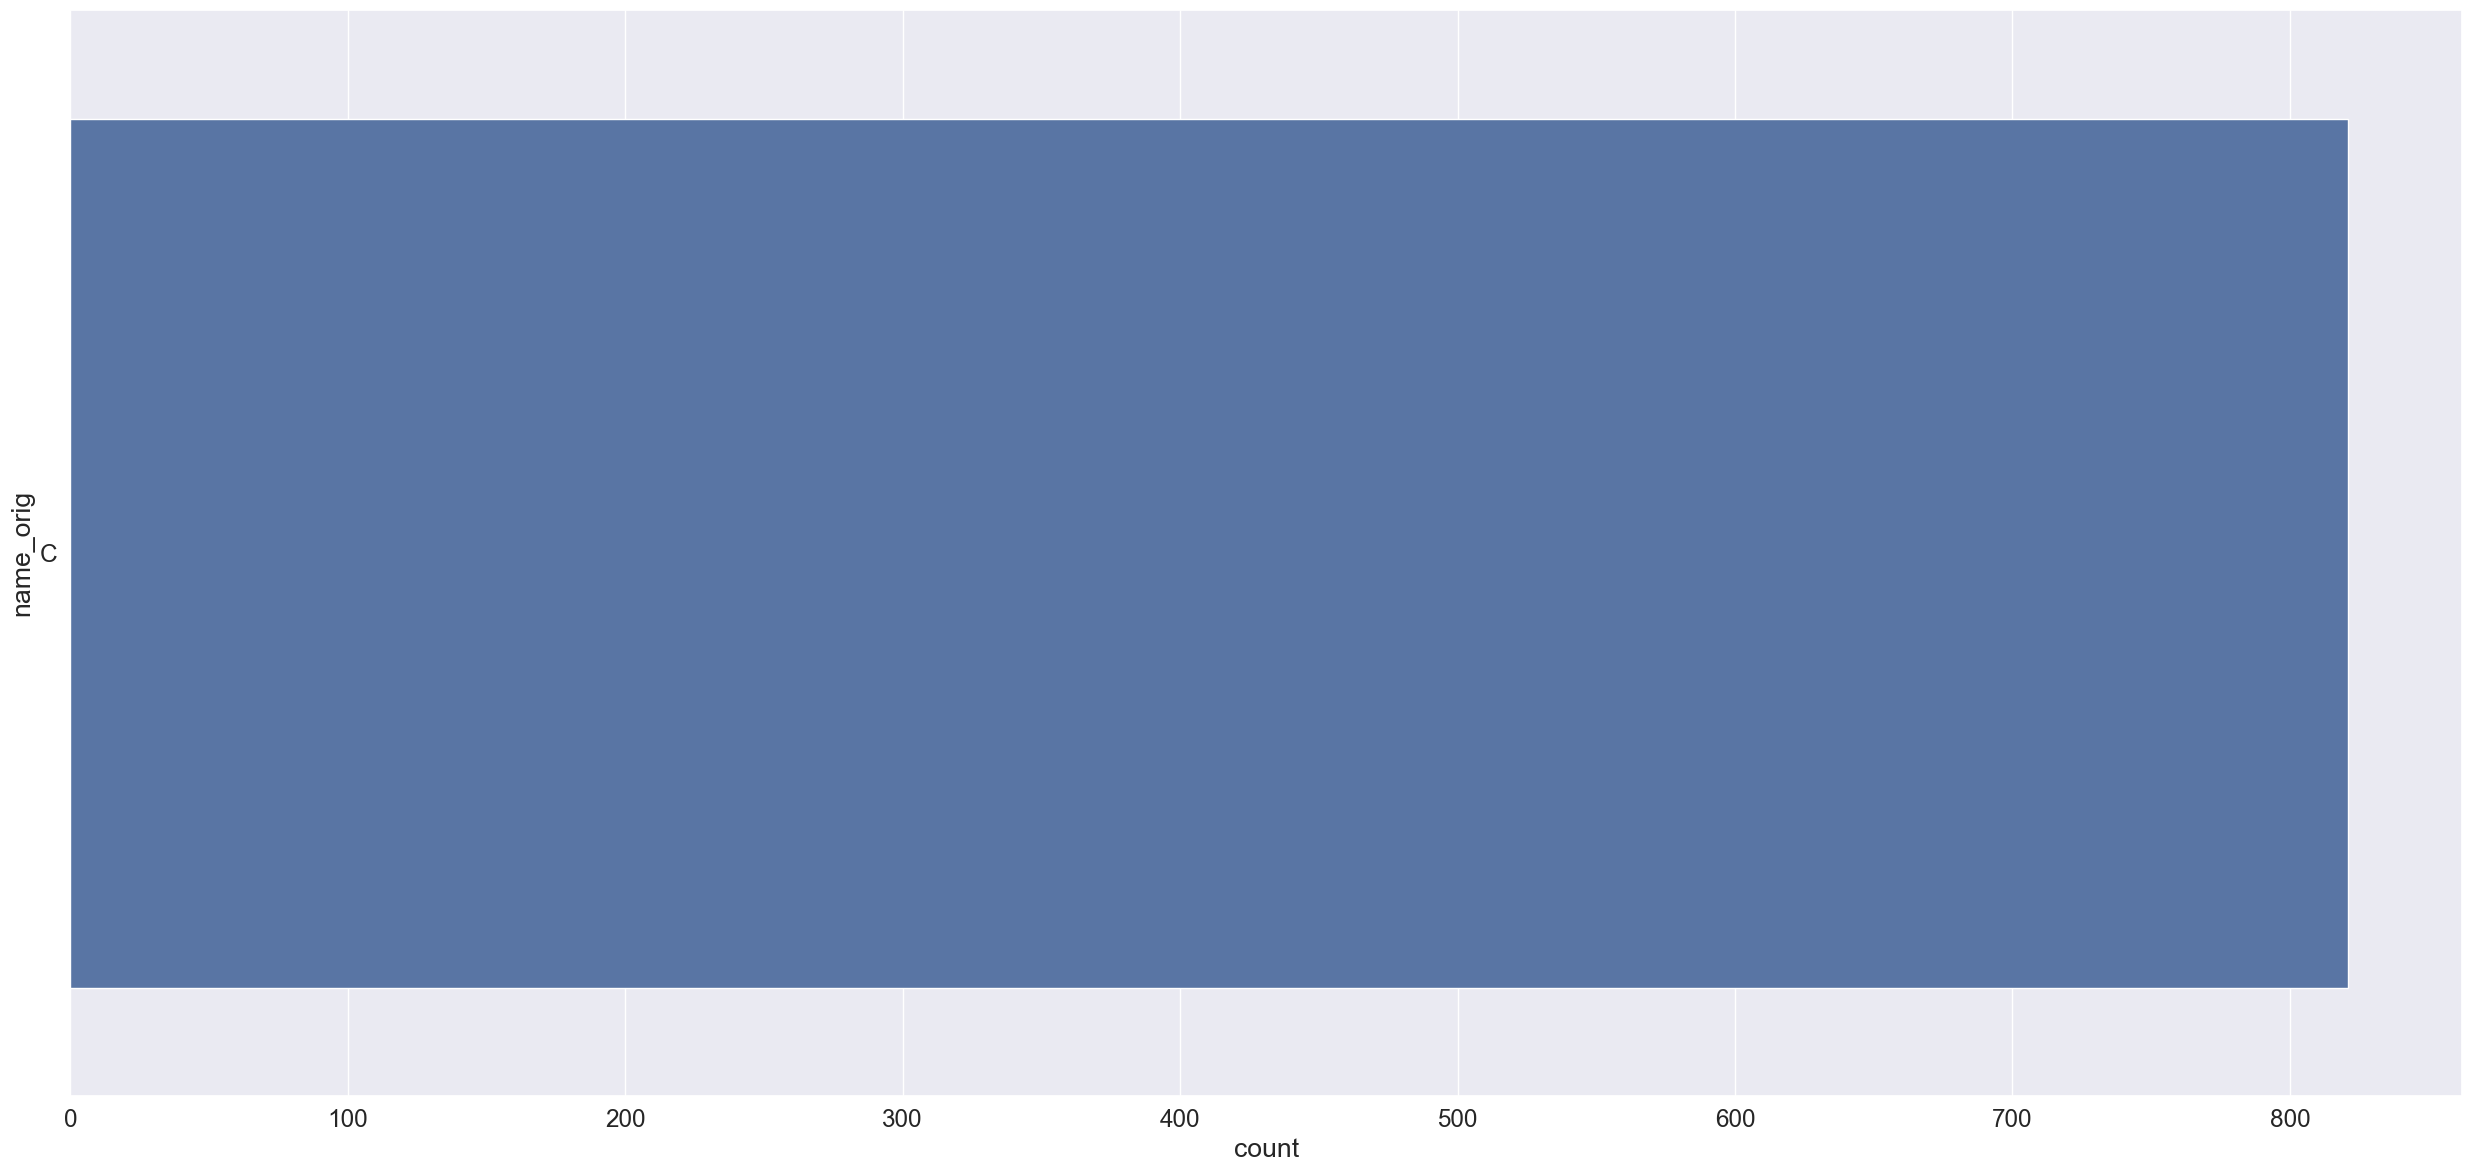

In [217]:
aux1 = df4[df4['is_fraud'] == 'yes']
sns.countplot(y='name_orig', data=aux1)
plt.tight_layout()
plt.show();

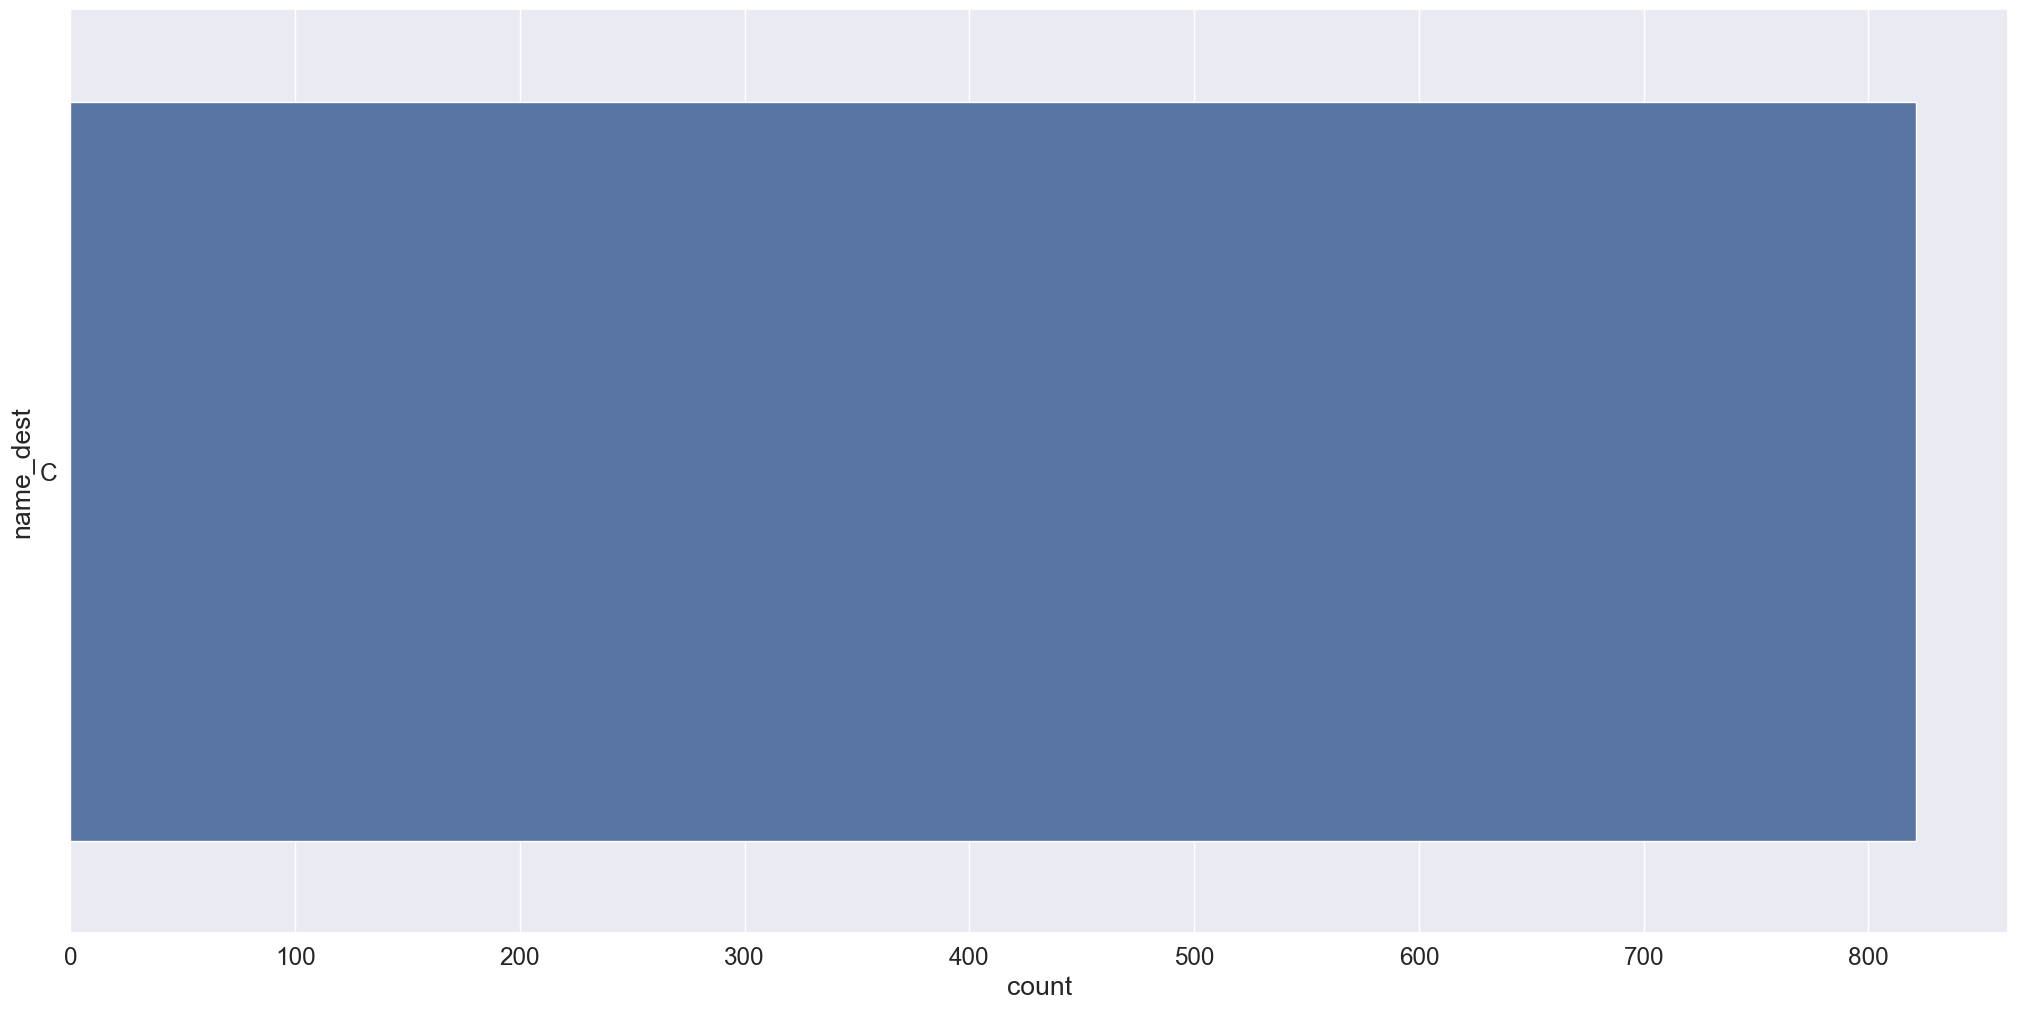

In [218]:
sns.countplot(y='name_dest', data=aux1);

H2 All the fraud amount is greater than 10.000.

**TRUE**: The values are greater than 10.000. But it's important to note that the no-fraud values is greater than 100.000 also.

มีทั้งเคสที่เป็น Fraud และ non-fraud ที่มีค่ามากกว่า 10k

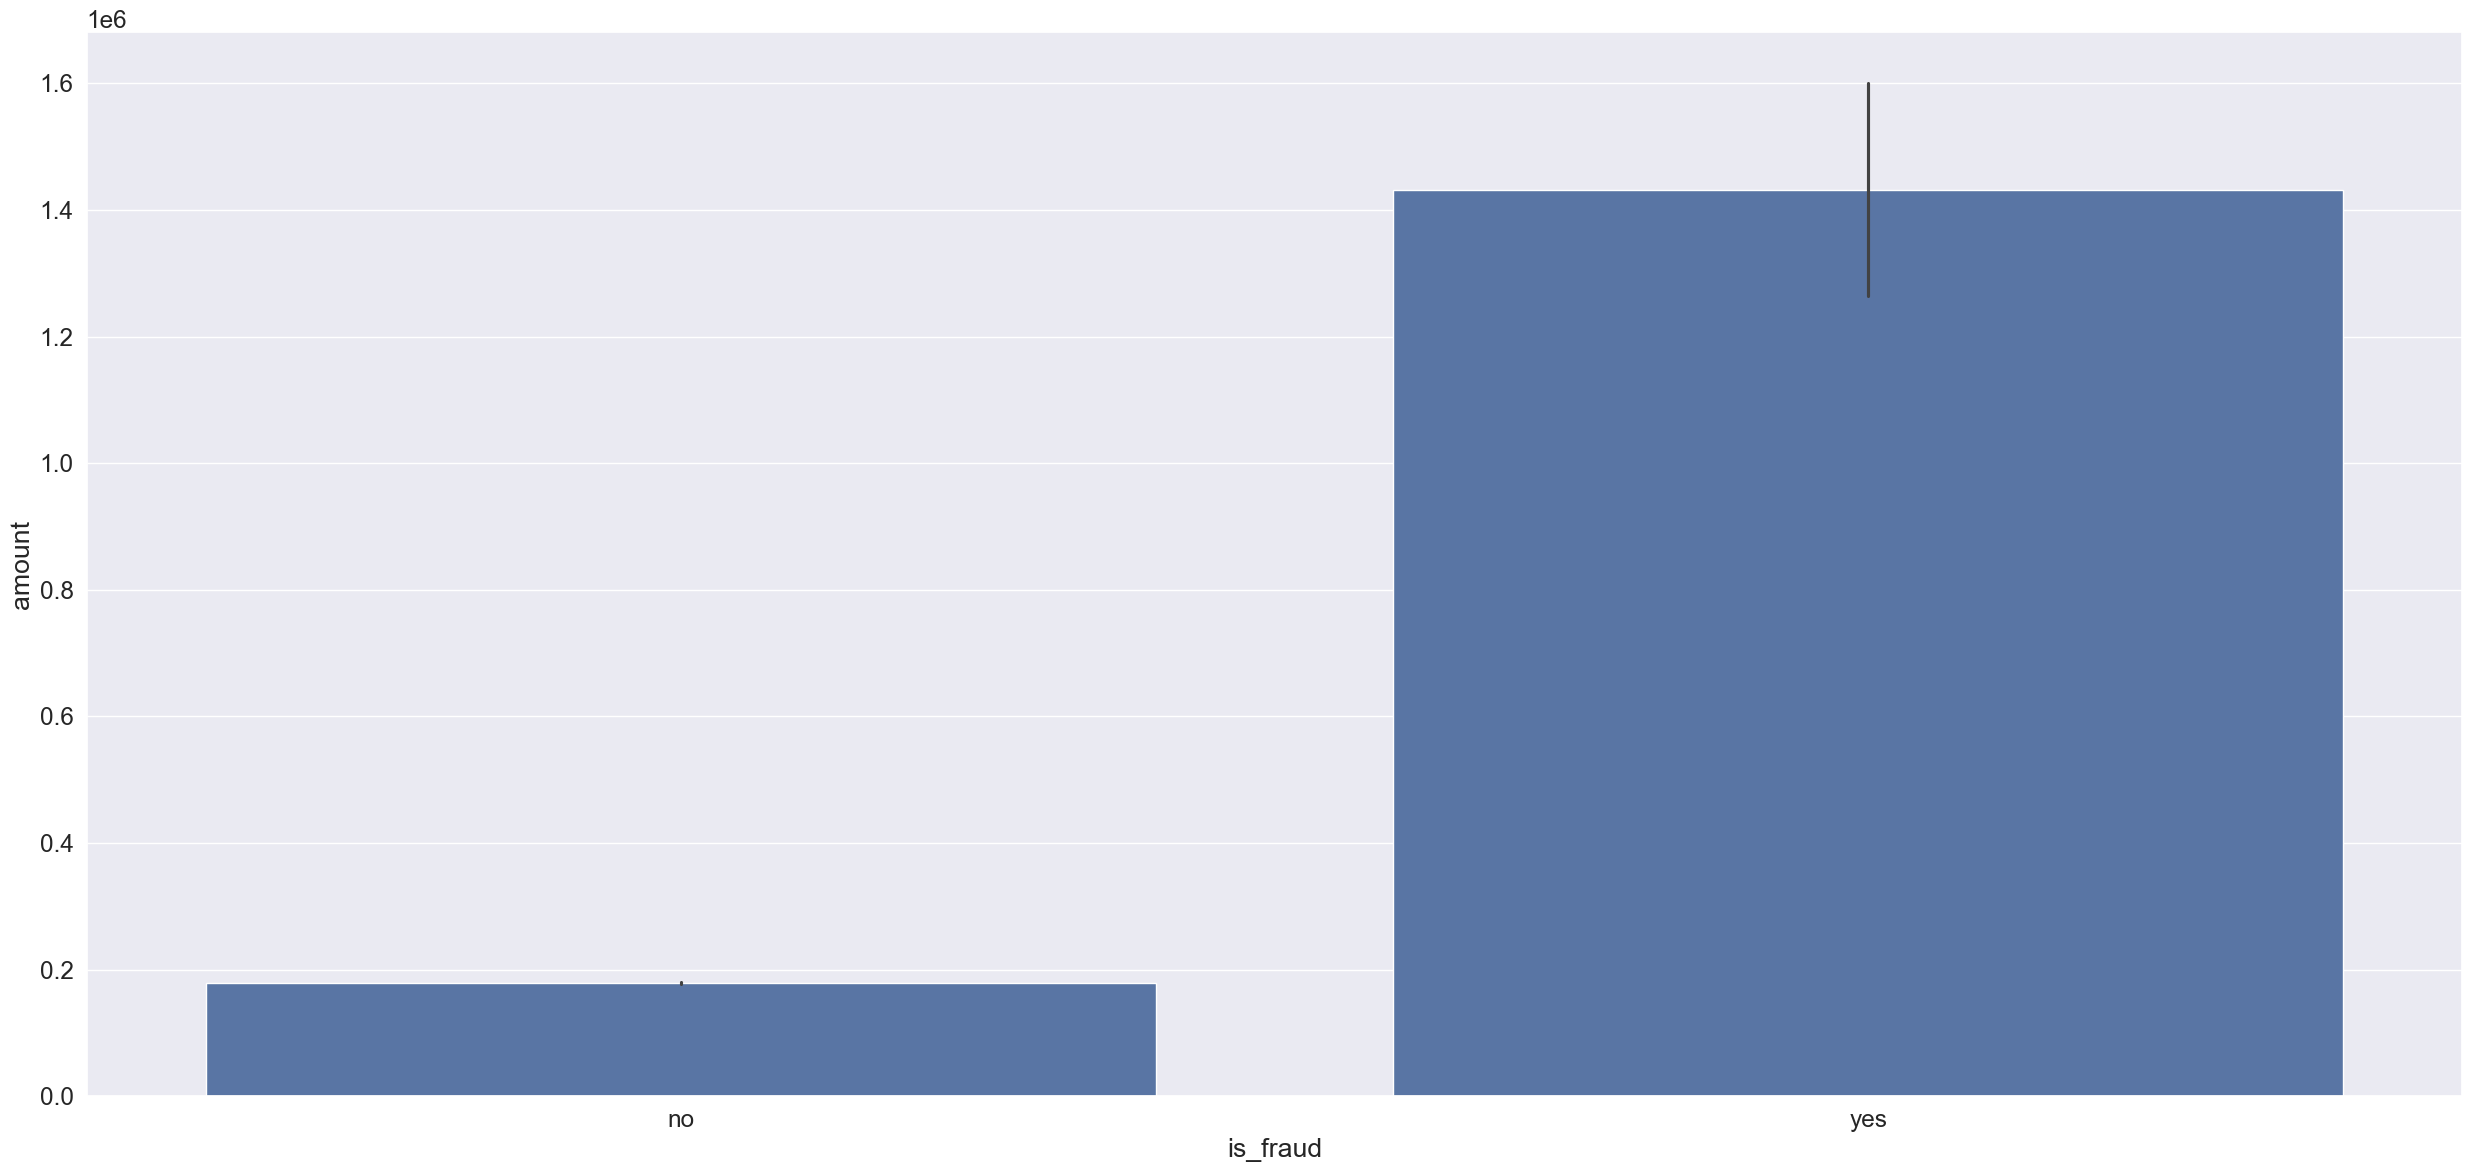

In [219]:
sns.barplot(y='amount', x='is_fraud', data=df4)

plt.tight_layout()
plt.show();

H3 60% of fraud transaction occours using cash-out-type method.

**FALSE**: The fraud transaction occours in **transfer** and **cash-out** type. However they're almost the same value.

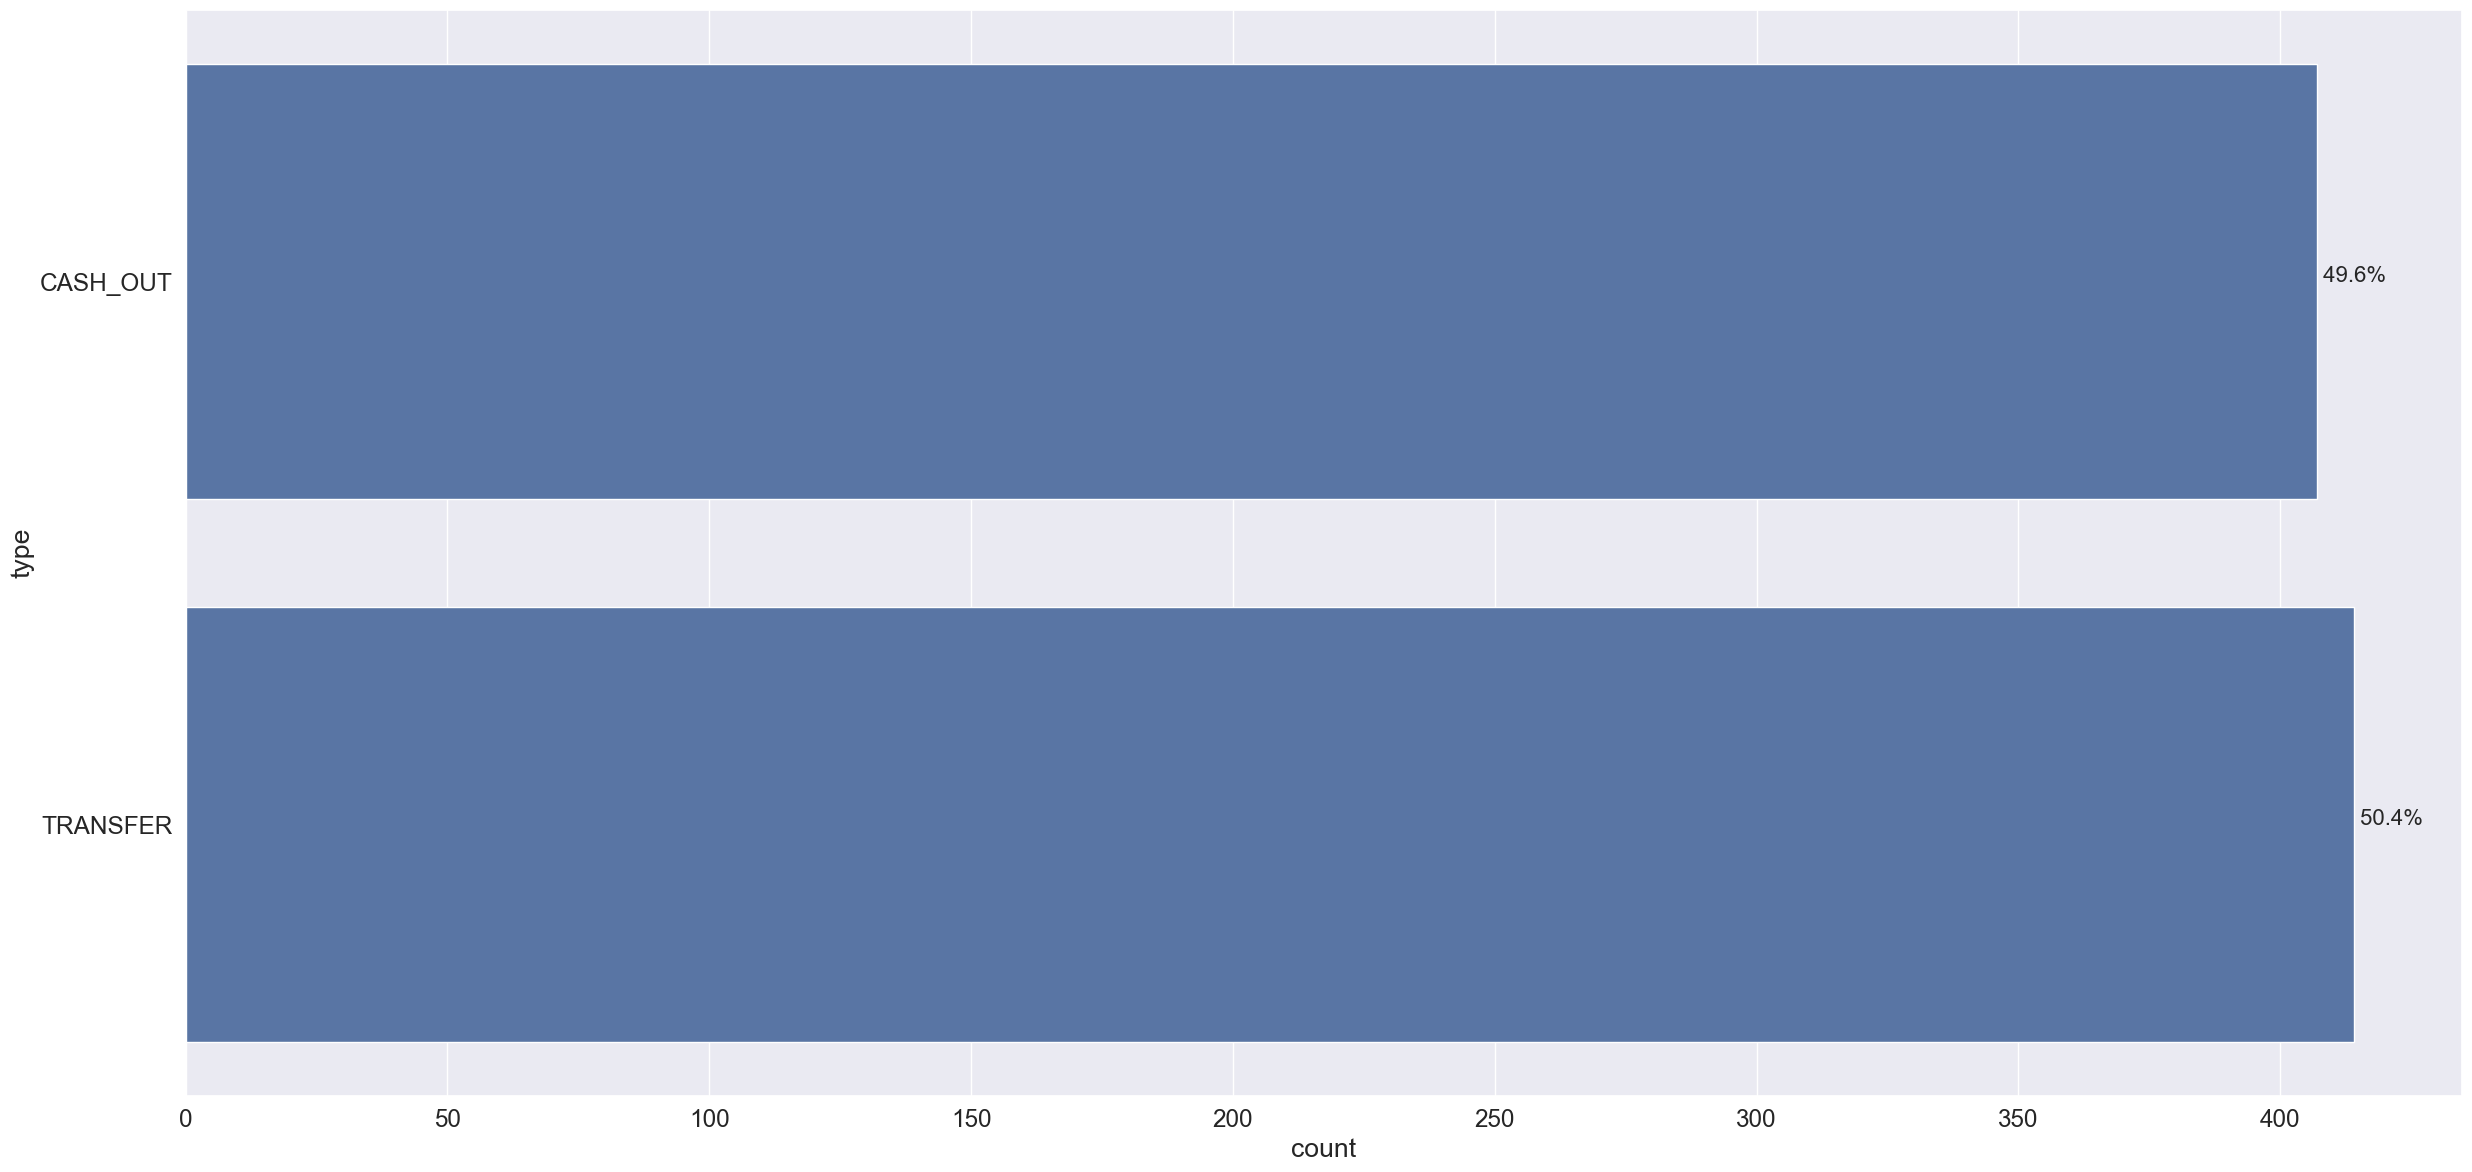

In [220]:
aux1 = df4[df4['is_fraud'] == 'yes']
ax = sns.countplot(y='type', data=aux1)

total = aux1['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.tight_layout()
plt.show()

To see the complete transiction-type and I'll plot them here.

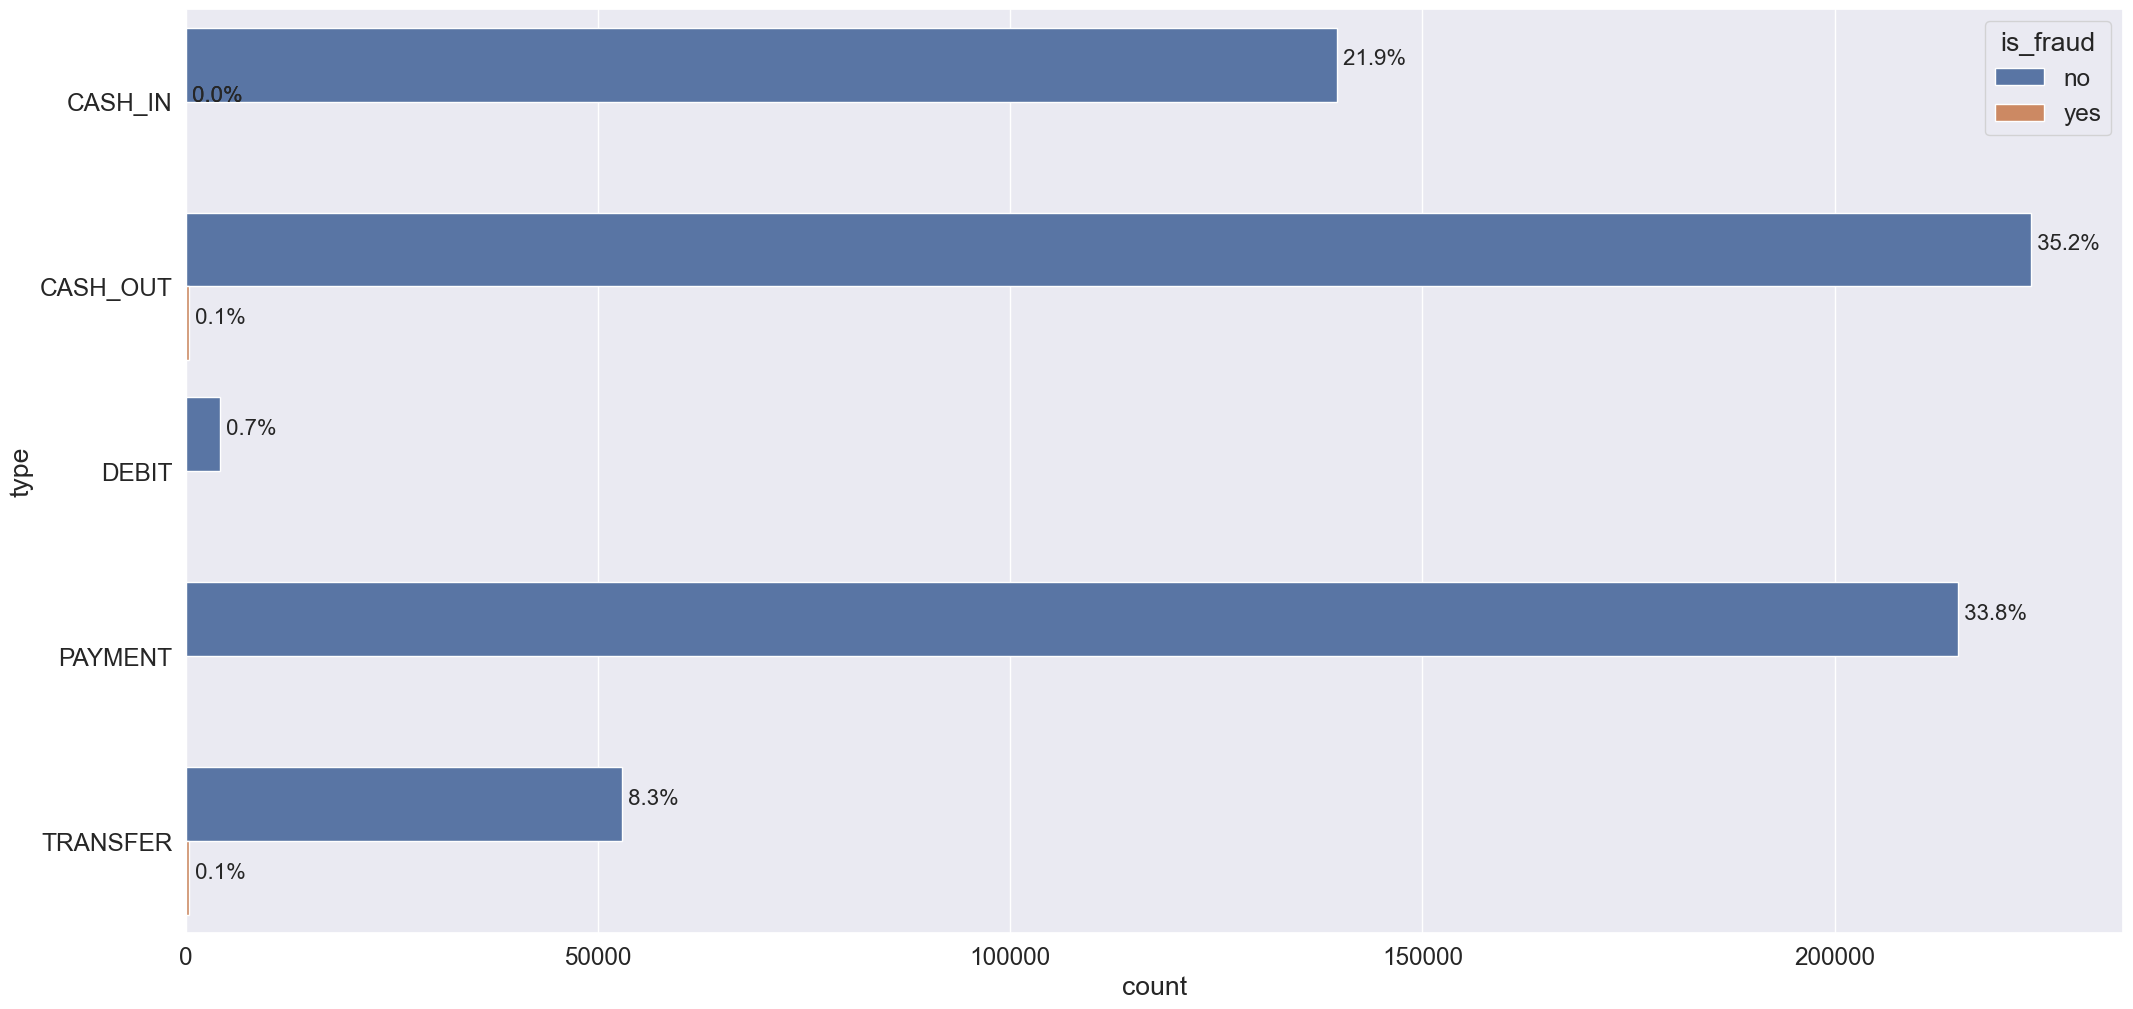

In [221]:
ax = sns.countplot(y='type', hue='is_fraud', data=df4)

total = df4['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

H4 Values greater than 100.000 occours using transfers-type method.

**FALSE**: The majority transactions occours in **trasnfer-type**, however transactions greater than 100.000 occour in **cash-out** and **cash-in** too.

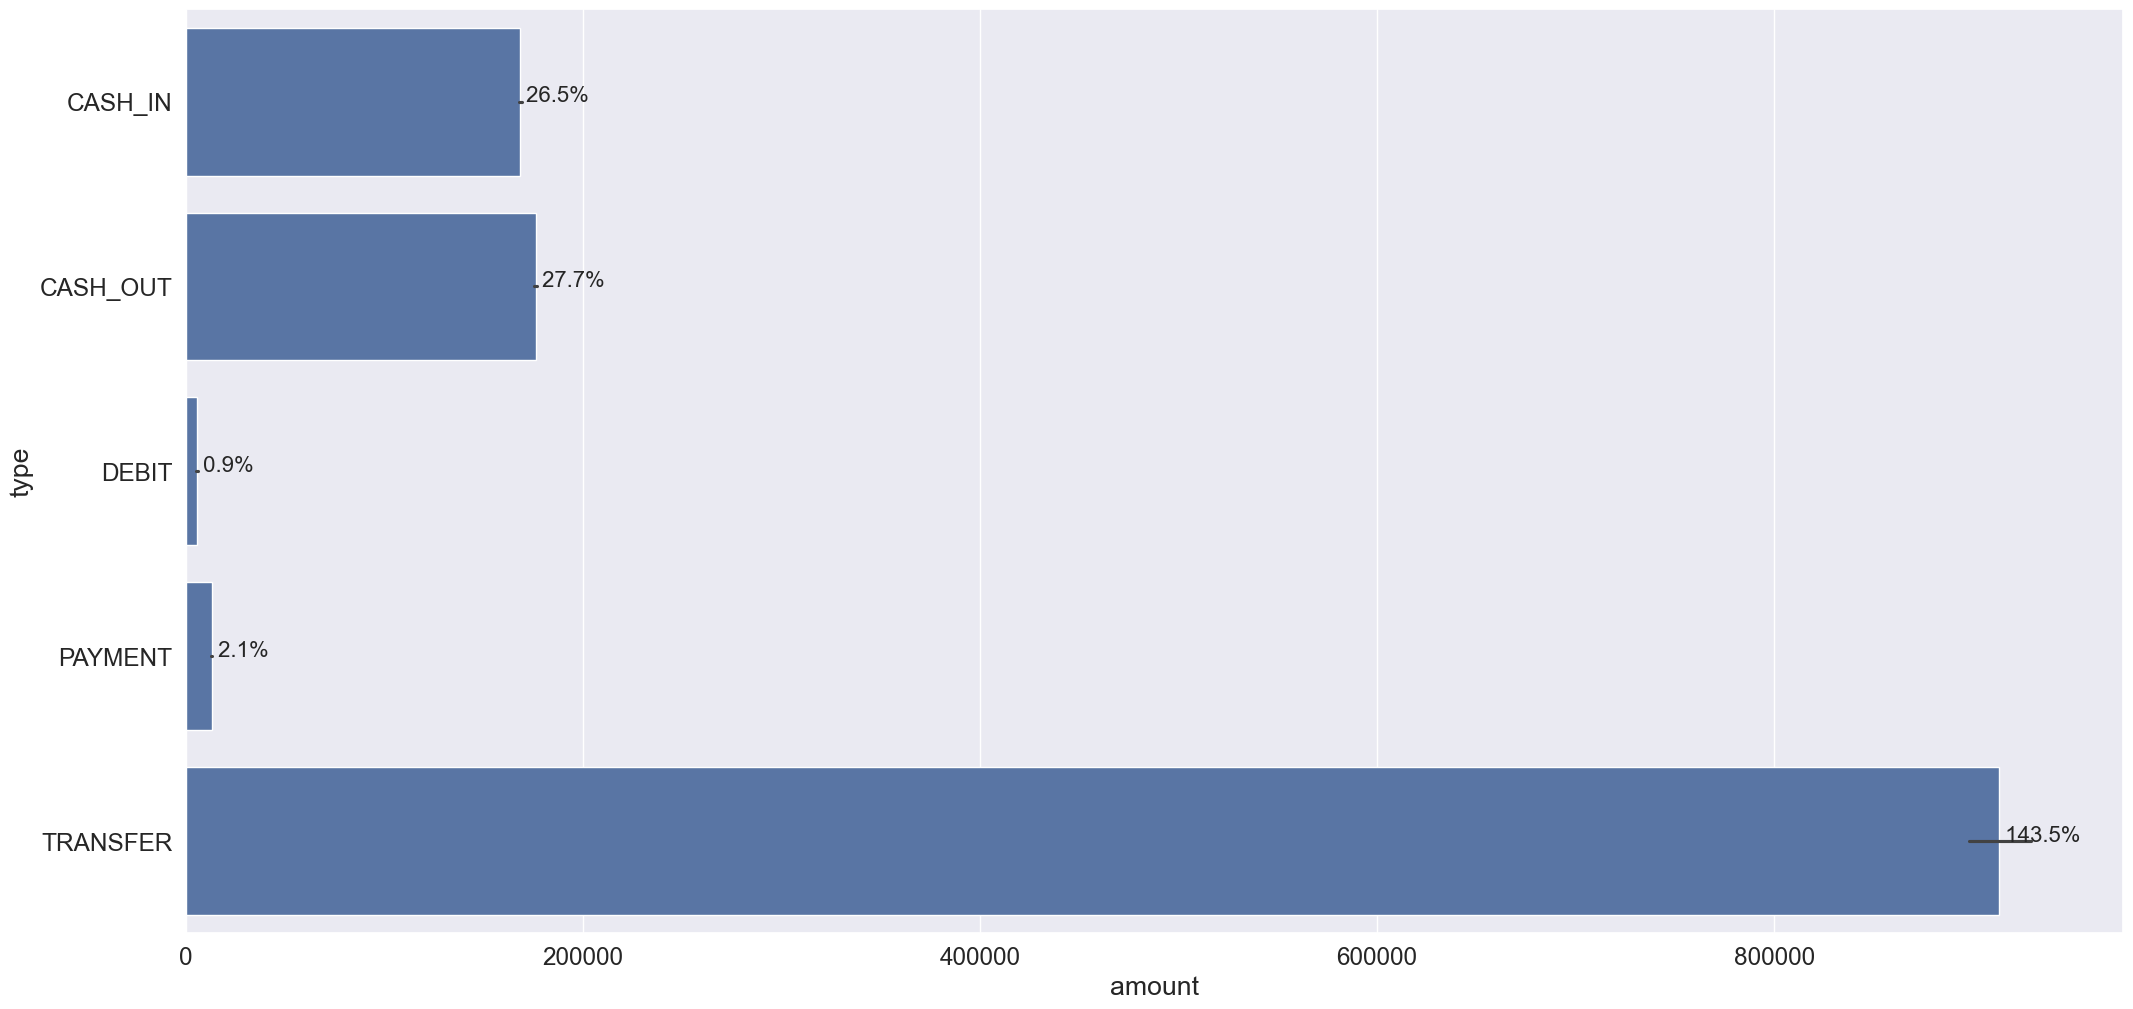

In [222]:
ax = sns.barplot(y='type', x='amount', data=df4);

total = df4['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

H5 Fraud transactions occours at least in 3 days.

**TRUE**: The values for transactions and days in fraud aren't similar.

ค่าของจำนวนธุรกรรมกับจำนวนวันที่พบการทุจริต ไม่สอดคล้องกันโดยตรง

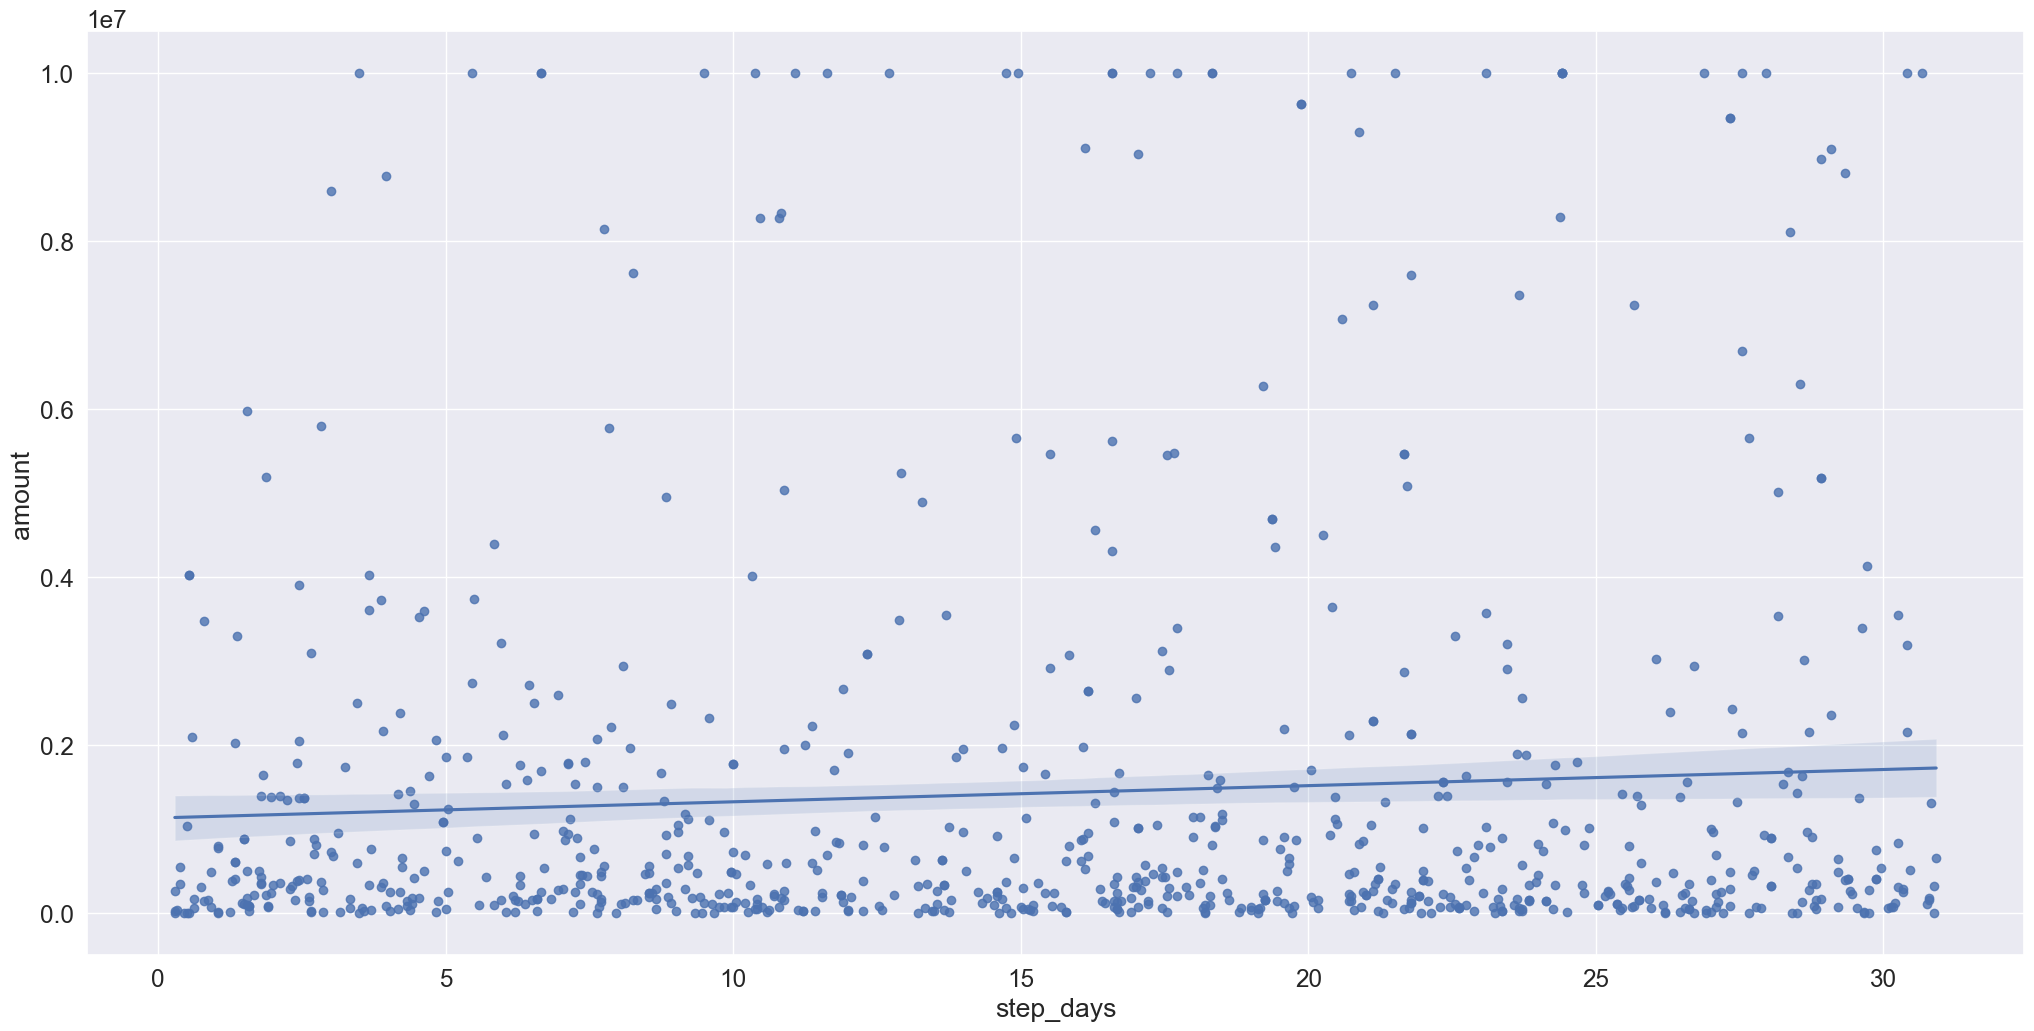

In [223]:
aux1 = df4[df4['is_fraud'] == 'yes']
sns.regplot(x='step_days', y='amount', data=aux1);

### 4.3 Multivariaty Analysis
#### 4.3.1 Numerical Analysis
แสดงเฉพาะ ครึ่งล่าง ของตาราง

ค่าใกล้ 1 → ความสัมพันธ์เชิงบวกสูง

ค่าใกล้ -1 → ความสัมพันธ์เชิงลบสูง

ค่าใกล้ 0 → ไม่มีความสัมพันธ์

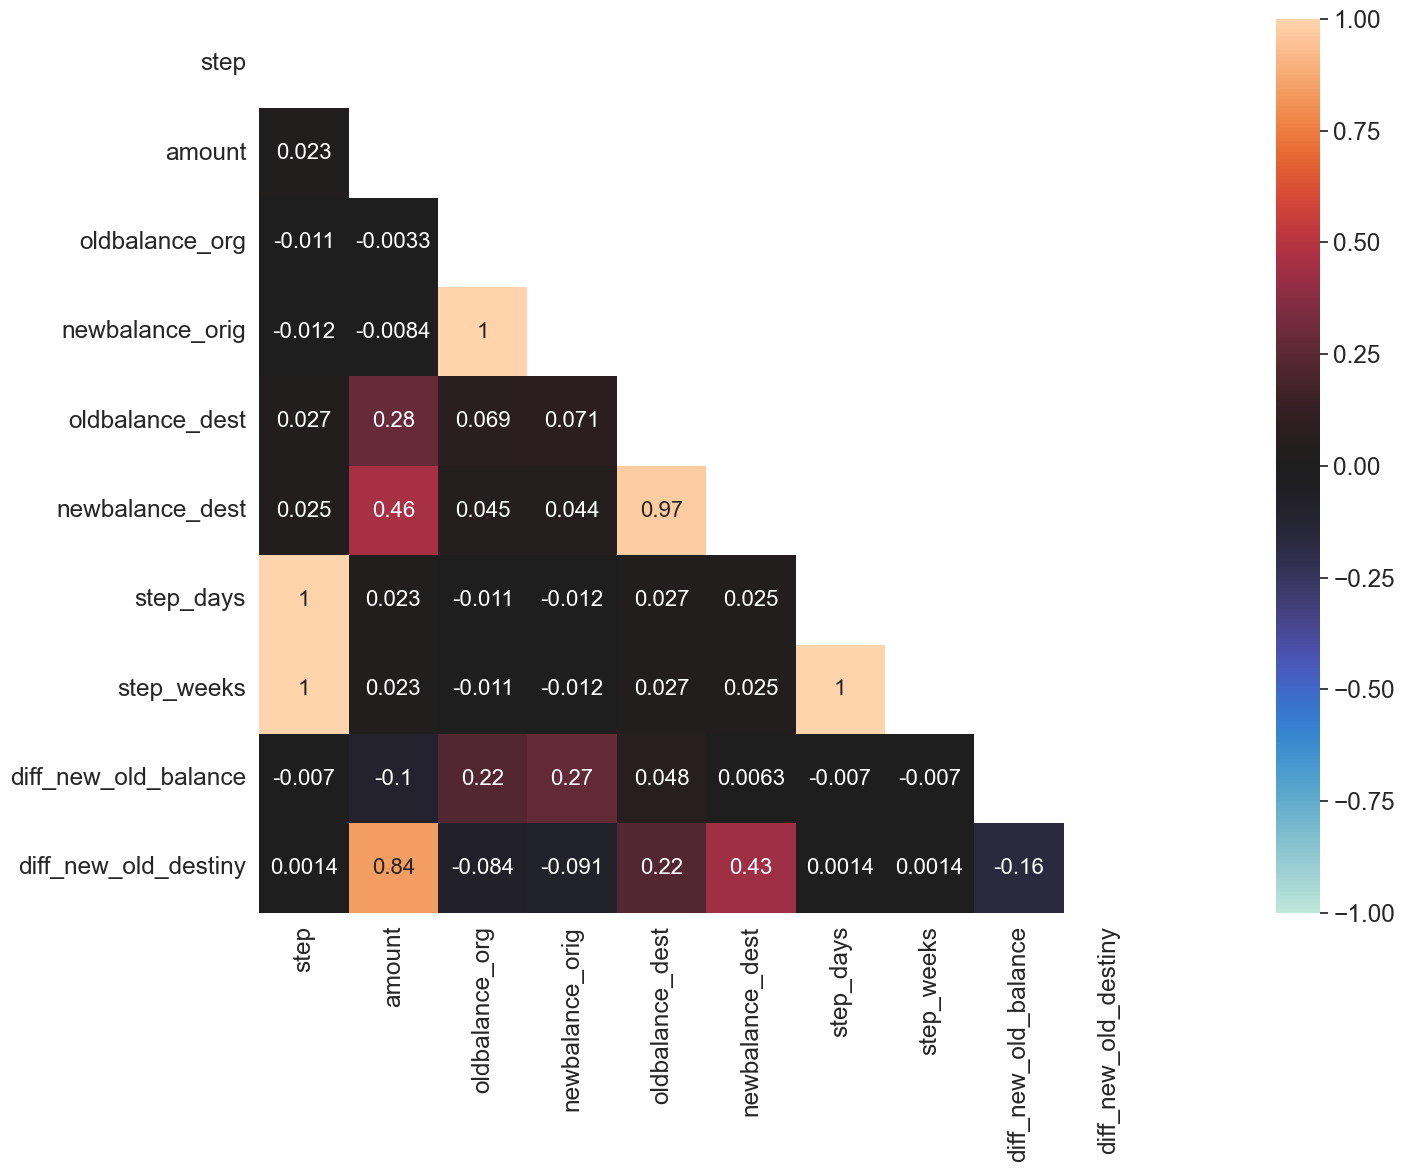

In [224]:
corr = num_attributes.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=-1, center=0, vmax=1, square=True)

plt.tight_layout()
plt.show()

### 4.3.2 Categorical Variables

In [225]:
##columns
df4[columns].isnull().sum()

type                0
name_orig           0
name_dest           0
is_fraud            0
is_flagged_fraud    0
dtype: int64

Cramér's V เป็นสถิติที่ใช้วัดความสัมพันธ์ระหว่างตัวแปรเชิงหมวดหมู่ (categorical variables)

ค่าจะอยู่ระหว่าง 0 ถึง 1

0 หมายถึง ไม่มีความสัมพันธ์

1 หมายถึง ความสัมพันธ์สมบูรณ์แบบ

ตัวแปรหมวดหมู่แต่ละคู่ในข้อมูลมีความสัมพันธ์กันมากน้อยแค่ไหน

In [226]:
dict_corr = {}
columns = cat_attributes.columns.tolist()

for column in columns:
    dict_corr[column] = {}
    
    for column2 in columns:
        dict_corr[column][column2] ={} ##= calcCramerV(cat_attributes[column], cat_attributes[column2])

dict_corr
##corr = pd.DataFrame(dict_corr)

{'type': {'type': {},
  'name_orig': {},
  'name_dest': {},
  'is_fraud': {},
  'is_flagged_fraud': {}},
 'name_orig': {'type': {},
  'name_orig': {},
  'name_dest': {},
  'is_fraud': {},
  'is_flagged_fraud': {}},
 'name_dest': {'type': {},
  'name_orig': {},
  'name_dest': {},
  'is_fraud': {},
  'is_flagged_fraud': {}},
 'is_fraud': {'type': {},
  'name_orig': {},
  'name_dest': {},
  'is_fraud': {},
  'is_flagged_fraud': {}},
 'is_flagged_fraud': {'type': {},
  'name_orig': {},
  'name_dest': {},
  'is_fraud': {},
  'is_flagged_fraud': {}}}

In [227]:
dict_corr = {}
columns = cat_attributes.columns.tolist()

#for column in columns:
#    dict_corr[column] = {}
    
#    for column2 in columns:
#        dict_corr[column][column2] = calcCramerV(cat_attributes[column], cat_attributes[column2])

#corr = pd.DataFrame(dict_corr)

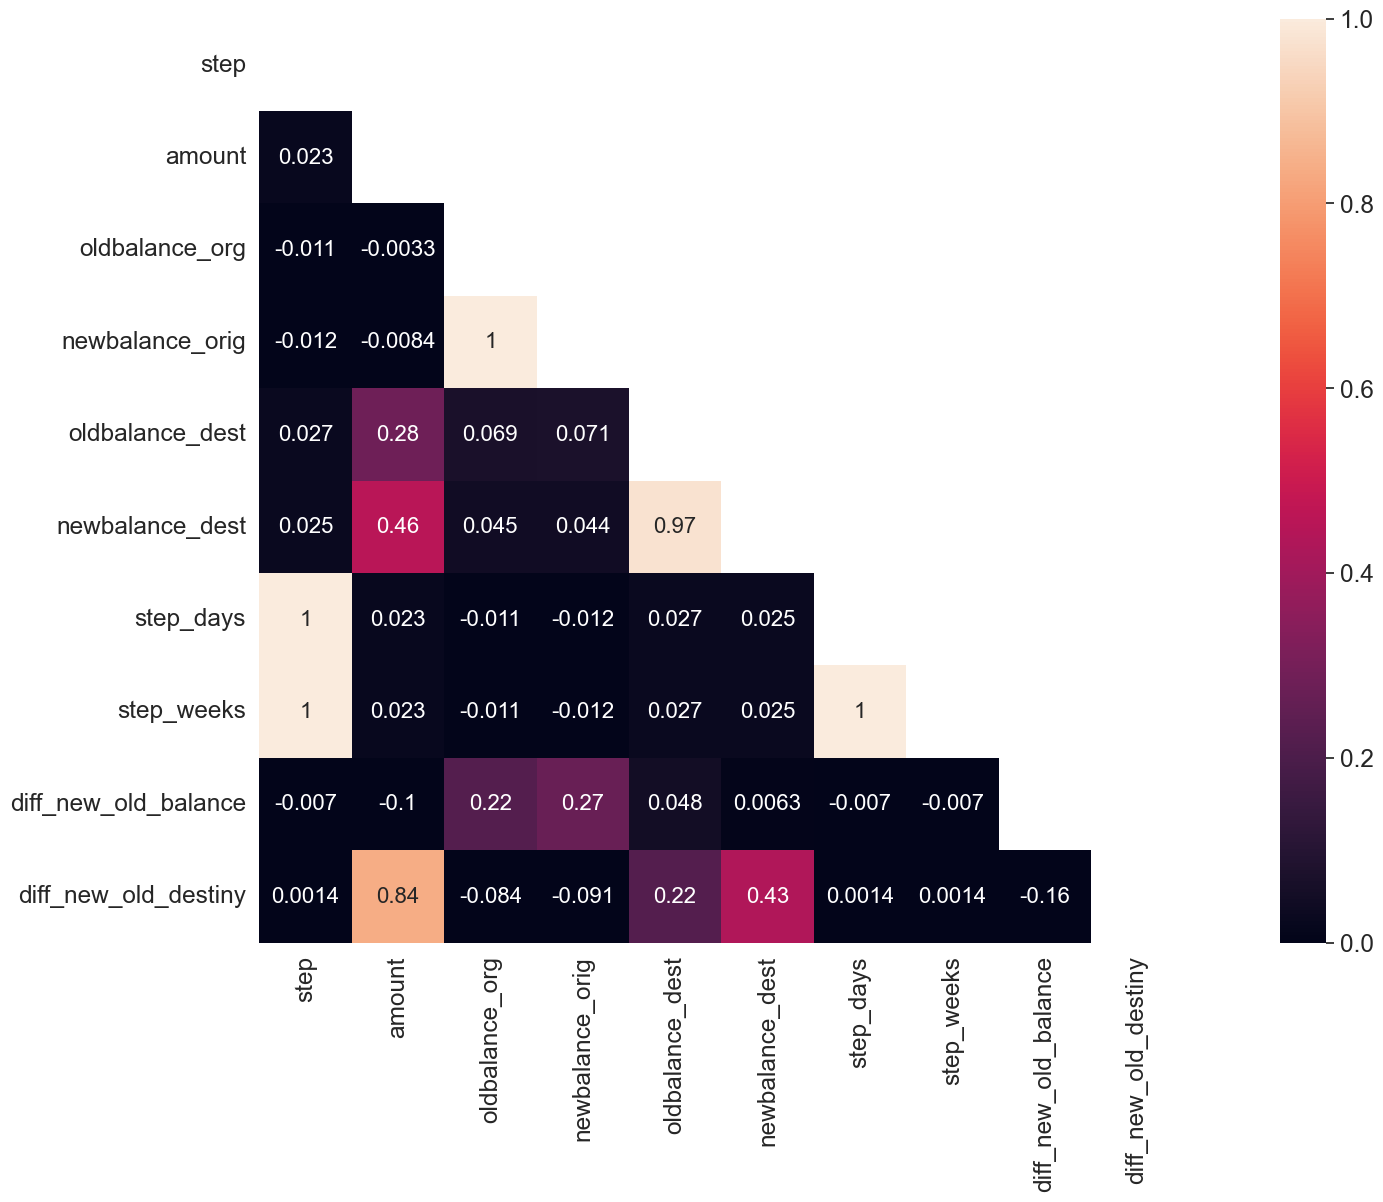

In [228]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=0, vmax=1, square=True)

## 5.0 Data Preparation

In [229]:
df5 = df4.copy()

### 5.1 Spliting into Train, Valid and Test

In [230]:
X = df5.drop(columns=['is_fraud', 'is_flagged_fraud', 'name_orig', 'name_dest', 
                      'step_weeks', 'step_days'], axis=1)
y = df5['is_fraud'].map({'yes': 1, 'no': 0})

In [231]:
# spliting into temp and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=.2, stratify=y)

In [232]:
# spliting into train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=.2, stratify=y_temp)

### 5.2 One Hot Encoder

In [233]:
ohe = OneHotEncoder(cols=['type'], use_cat_names=True)

X_train = ohe.fit_transform(X_train)
X_valid = ohe.transform(X_valid)

X_temp = ohe.fit_transform(X_temp)
X_test = ohe.transform(X_test)

### 5.3 Rescaling

In [234]:
num_columns = ['amount', 'oldbalance_org', 'newbalance_orig', 'oldbalance_dest', 'newbalance_dest',
               'diff_new_old_balance', 'diff_new_old_destiny']
mm = MinMaxScaler()
X_params = X_temp.copy()

X_train[num_columns] = mm.fit_transform(X_train[num_columns])
X_valid[num_columns] = mm.transform(X_valid[num_columns])

X_params[num_columns] = mm.fit_transform(X_temp[num_columns])
X_test[num_columns] = mm.transform(X_test[num_columns])
X_test[num_columns].head()

,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,diff_new_old_balance,diff_new_old_destiny
578630,0.011758,0.000000,0.000000,0.025005,0.030010,0.878805,0.089815
248692,0.000739,0.000000,0.000000,0.000769,0.000888,0.878805,0.070263
43980,0.000098,0.003514,0.003346,0.000129,0.000145,0.878309,0.069851
331603,0.002743,0.011211,0.015260,0.002908,0.002465,0.892600,0.068024
123136,0.005613,0.000277,0.008692,0.000247,0.000000,0.907037,0.068803


## 6.0 Feature Selection
### 6.1 Boruta

In [235]:
# X_boruta = X_params.values
# y_boruta = y_temp.values.ravel()

In [236]:
# boruta = BorutaPy(RandomForestClassifier(), n_estimators='auto')
# boruta.fit(X_boruta, y_boruta)

#### 6.1.1 Best Features

In [237]:
# cols_selected_boruta = boruta.support_.tolist()

In [238]:
# columns_selected = X_params.loc[:, cols_selected_boruta].columns.tolist()

In [239]:
# columns_selected

In [240]:
# ['step',
#  'amount',
#  'oldbalance_org',
#  'newbalance_orig',
#  'oldbalance_dest',
#  'newbalance_dest',
#  'diff_new_old_balance',
#  'diff_new_old_destiny',
#  'type_TRANSFER']

In [241]:
final_columns_selected = ['step', 'oldbalance_org', 
                          'newbalance_orig', 'newbalance_dest', 
                          'diff_new_old_balance', 'diff_new_old_destiny']
                          #'type_TRANSFER']

## 7.0 Machine Learning Modeling

In [242]:
X_train_cs = X_train[final_columns_selected]
X_valid_cs = X_valid[final_columns_selected]

X_temp_cs = X_temp[final_columns_selected]
X_test_cs = X_test[final_columns_selected]

X_params_cs = X_params[final_columns_selected]

### 7.1 Baseline

In [243]:
dummy = DummyClassifier()
dummy.fit(X_train_cs, y_train)

y_pred = dummy.predict(X_valid_cs)

In [244]:
from sklearn.metrics import accuracy_score

accuracy_score(y_valid, y_pred)

0.998713188346005

In [245]:
dummy_results = ml_scores('dummy', y_valid, y_pred)
dummy_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy,0.5,0.0,0.0,0.0,0.0


ฟังก์ชันนี้ เหมาะกับ binary classification (2 classes เท่านั้น)
- Balanced Accuracy	ค่าความแม่นยำที่คำนึงถึง class imbalance (เฉลี่ย recall ของแต่ละ class)
- Precision	ความแม่นยำของการทำนาย class 1
- Recall	ความสามารถในการจับ class 1 ได้ทั้งหมด
- F1	ค่าเฉลี่ยของ precision และ recall
- Kappa	Cohen's Kappa: วัดความสอดคล้องระหว่างโมเดลกับความจริง (เมื่อเทียบกับการเดาแบบสุ่ม)

#### 7.1.1 Classification Report

In [246]:
print(classification_report(y_valid, y_pred))
#support : จำนวนตัวอย่างของแต่ละ class ใน y_valid (ค่าจริง)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.00      0.00      0.00       131

    accuracy                           1.00    101802
   macro avg       0.50      0.50      0.50    101802
weighted avg       1.00      1.00      1.00    101802



#### 7.1.2 Cross Validation

In [247]:
dummy_cv = ml_cv_results('Dummy', DummyClassifier(), X_temp, y_temp) #ml_cv_results('Dummy', DummyClassifier(), X_temp, y_tempม average='weighted')) กรณี > 2 class
dummy_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Dummy,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0


### 7.2 Logistic Regression

In [248]:
lg = LogisticRegression()
lg.fit(X_train_cs, y_train)

y_pred = lg.predict(X_valid_cs)

In [249]:
lg_results = ml_scores('Logistic Regression', y_valid, y_pred)
lg_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.5,0.0,0.0,0.0,0.0


#### 7.2.1 Classification Report

In [250]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.00      0.00      0.00       131

    accuracy                           1.00    101802
   macro avg       0.50      0.50      0.50    101802
weighted avg       1.00      1.00      1.00    101802



#### 7.2.2 Cross Validation

In [251]:
lg_cv = ml_cv_results('Logistic Regression',
                      LogisticRegression(), 
                      X_temp_cs, y_temp)
lg_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.538 +/- 0.018,1.0 +/- 0.0,0.076 +/- 0.036,0.139 +/- 0.061,0.139 +/- 0.061


## 7.3 K Nearest Neighbors

In [252]:
knn = KNeighborsClassifier()
knn.fit(X_train_cs, y_train)

y_pred = knn.predict(X_valid_cs)

In [253]:
knn_results = ml_scores('K Nearest Neighbors', y_valid, y_pred)
knn_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.584,1.0,0.168,0.288,0.287


#### 7.3.1 Classification Report

In [254]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       1.00      0.17      0.29       131

    accuracy                           1.00    101802
   macro avg       1.00      0.58      0.64    101802
weighted avg       1.00      1.00      1.00    101802



#### 7.3.2 Cross Validation

In [255]:
knn_cv = ml_cv_results('K Nearest Neighbors', KNeighborsClassifier(), 
                       X_temp_cs, y_temp)
knn_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.728 +/- 0.014,0.941 +/- 0.035,0.455 +/- 0.029,0.613 +/- 0.03,0.613 +/- 0.03


### 7.4 Support Vector Machine

In [256]:
svm = SVC()
svm.fit(X_train_cs, y_train)

y_pred = svm.predict(X_valid_cs)

In [257]:
svm_results = ml_scores('SVM', y_valid, y_pred)
svm_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.5,0.0,0.0,0.0,0.0


#### 7.4.1 Classification Report

In [258]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.00      0.00      0.00       131

    accuracy                           1.00    101802
   macro avg       0.50      0.50      0.50    101802
weighted avg       1.00      1.00      1.00    101802



#### 7.4.2 Cross Validation

In [259]:
svm_cv = ml_cv_results('SVM', SVC(), X_temp_cs, y_temp)
svm_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.603 +/- 0.014,1.0 +/- 0.0,0.205 +/- 0.029,0.34 +/- 0.039,0.34 +/- 0.039


### 7.5 Random Forest

In [260]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_cs, y_train)

y_pred = rf.predict(X_valid_cs)

In [261]:
rf_results = ml_scores('Random Forest', y_valid, y_pred)
rf_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.794,0.928,0.588,0.72,0.719


#### 7.5.1 Classification Report

In [262]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.93      0.59      0.72       131

    accuracy                           1.00    101802
   macro avg       0.96      0.79      0.86    101802
weighted avg       1.00      1.00      1.00    101802



#### 7.5.2 Cross Validation

In [263]:
rf_cv = ml_cv_results('Random Forest', 
                      RandomForestClassifier(), 
                      X_temp_cs, y_temp)
rf_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.812 +/- 0.032,0.941 +/- 0.027,0.624 +/- 0.065,0.748 +/- 0.047,0.748 +/- 0.047


### 7.6 XGBoost

In [264]:
xgb = XGBClassifier()
xgb.fit(X_train_cs, y_train)

y_pred = xgb.predict(X_valid_cs)

In [265]:
xgb_results = ml_scores('XGBoost', y_valid, y_pred)
xgb_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.809,0.853,0.618,0.717,0.717


#### 7.6.1 Classification Report

In [266]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.85      0.62      0.72       131

    accuracy                           1.00    101802
   macro avg       0.93      0.81      0.86    101802
weighted avg       1.00      1.00      1.00    101802



#### 7.6.2 Cross Validation

In [267]:
xgb_cv = ml_cv_results('XGBoost', XGBClassifier(),
                       X_temp_cs, y_temp)
xgb_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.833 +/- 0.027,0.862 +/- 0.032,0.665 +/- 0.054,0.749 +/- 0.036,0.749 +/- 0.036


### 7.7 LightGBM

In [268]:
lightgbm = LGBMClassifier()
lightgbm.fit(X_train_cs, y_train)

y_pred = lightgbm.predict(X_valid_cs)

[LightGBM] [Info] Number of positive: 526, number of negative: 406681
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 407207, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001292 -> initscore=-6.650483
[LightGBM] [Info] Start training from score -6.650483


In [269]:
lightgbm_results = ml_scores('LightGBM', y_valid, y_pred)
lightgbm_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
LightGBM,0.701,0.139,0.405,0.207,0.206


#### 7.7.1 Classification Report

In [270]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.14      0.40      0.21       131

    accuracy                           1.00    101802
   macro avg       0.57      0.70      0.60    101802
weighted avg       1.00      1.00      1.00    101802



#### 7.7.2 Cross Validation

In [271]:
lightgbm_cv = ml_cv_results('LightGDM', LGBMClassifier(), 
                            X_temp_cs, y_temp)
lightgbm_cv

Fold K=1
[LightGBM] [Info] Number of positive: 526, number of negative: 406681
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 407207, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001292 -> initscore=-6.650483
[LightGBM] [Info] Start training from score -6.650483
Fold K=2
[LightGBM] [Info] Number of positive: 526, number of negative: 406681
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 407207, number of used features: 6
[L

,Balanced Accuracy,Precision,Recall,F1,Kappa
LightGDM,0.709 +/- 0.049,0.203 +/- 0.091,0.422 +/- 0.098,0.257 +/- 0.094,0.256 +/- 0.094


### 7.8 Comparing Model's Performance

#### 7.8.1 Single Performance

In [272]:
modeling_performance = pd.concat([dummy_results, lg_results, knn_results, 
                                  rf_results, xgb_results, lightgbm_results,
                                 svm_results])
modeling_performance.sort_values(by="F1", ascending=True)

,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy,0.500,0.000,0.000,0.000,0.000
Logistic Regression,0.500,0.000,0.000,0.000,0.000
SVM,0.500,0.000,0.000,0.000,0.000
LightGBM,0.701,0.139,0.405,0.207,0.206
K Nearest Neighbors,0.584,1.000,0.168,0.288,0.287
XGBoost,0.809,0.853,0.618,0.717,0.717
Random Forest,0.794,0.928,0.588,0.720,0.719


#### 7.8.2 Cross Validation Performance

In [273]:
modeling_performance_cv = pd.concat([dummy_cv, lg_cv, knn_cv, rf_cv, 
                                     xgb_cv, lightgbm_cv, svm_cv])

modeling_performance_cv.sort_values(by="F1", ascending=True)

,Balanced Accuracy,Precision,Recall,F1,Kappa
Dummy,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0
Logistic Regression,0.538 +/- 0.018,1.0 +/- 0.0,0.076 +/- 0.036,0.139 +/- 0.061,0.139 +/- 0.061
LightGDM,0.709 +/- 0.049,0.203 +/- 0.091,0.422 +/- 0.098,0.257 +/- 0.094,0.256 +/- 0.094
SVM,0.603 +/- 0.014,1.0 +/- 0.0,0.205 +/- 0.029,0.34 +/- 0.039,0.34 +/- 0.039
K Nearest Neighbors,0.728 +/- 0.014,0.941 +/- 0.035,0.455 +/- 0.029,0.613 +/- 0.03,0.613 +/- 0.03
Random Forest,0.812 +/- 0.032,0.941 +/- 0.027,0.624 +/- 0.065,0.748 +/- 0.047,0.748 +/- 0.047
XGBoost,0.833 +/- 0.027,0.862 +/- 0.032,0.665 +/- 0.054,0.749 +/- 0.036,0.749 +/- 0.036


## 8.0 Hyperparameter Fine Tuning

In [274]:
f1 = make_scorer(f1_score)

In [275]:
params = {
    'booster': ['gbtree', 'gblinear', 'dart'],
    'eta': [0.3, 0.1, 0.01],
    'scale_pos_weight': [1, 774, 508, 99]
}

In [ ]:
gs = GridSearchCV(XGBClassifier(), 
                  param_grid=params, 
                  scoring=f1, 
                  cv=StratifiedKFold(n_splits=5))

gs.fit(X_params_cs, y_temp)

In [ ]:
best_params = gs.best_params_
best_params

{'booster': 'gbtree', 'eta': 0.1, 'scale_pos_weight': 1}

In [ ]:
best_params = {'booster': 'gbtree', 'eta': 0.3, 'scale_pos_weight': 1}

In [ ]:
gs.best_score_

np.float64(0.7614882463185995)

### 8.1 Results

In [ ]:
xgb_gs = XGBClassifier(
    booster=best_params['booster'],
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
)

In [ ]:
xgb_gs.fit(X_train_cs, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [ ]:
y_pred = xgb_gs.predict(X_valid_cs)

#### 8.1.2 Single Results

In [ ]:
xgb_gs_results = ml_scores('XGBoost GS', y_valid, y_pred)
xgb_gs_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost GS,0.809,0.853,0.618,0.717,0.717


#### 8.1.3 Cross Validation

In [ ]:
xgb_gs_cv = ml_cv_results('XGBoost GS', xgb_gs, X_temp_cs, y_temp)
xgb_gs_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost GS,0.834 +/- 0.016,0.875 +/- 0.049,0.668 +/- 0.032,0.756 +/- 0.018,0.756 +/- 0.018


## 9.0 Conclusions

### 9.1 Final Model

In [ ]:
final_model = XGBClassifier(
    booster=best_params['booster'],
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
)

final_model.fit(X_params_cs, y_temp)

,objective,'binary:logistic'
,base_score,None
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


#### 9.1.1 Unseen Data Score

In [ ]:
y_pred = final_model.predict(X_test_cs)

In [ ]:
unseen_scores = ml_scores('unseen', y_test, y_pred)
unseen_scores

,Balanced Accuracy,Precision,Recall,F1,Kappa
unseen,0.844,0.856,0.689,0.764,0.763


### 9.2 Blocker Fraud Company Expasion

#### 9.2.1 The company receives 25% of each transaction value truly detected as fraud.

In [ ]:
df_test = df5.loc[X_test.index, :]
df_test['predictions'] = y_pred

In [ ]:
aux1 = df_test[(df_test['is_fraud'] == 'yes') & (df_test['predictions'] == 1)]
receives = aux1['amount'].sum() * 0.25

In [ ]:
print('The company can receive %.2f detecting fraud transactions.' % (receives))

The company can receive 49648824.91 detecting fraud transactions.


#### 9.2.2 The company receives 5% of each transaction value detected as fraud, however the transaction is legitimate.

In [ ]:
aux1 = df_test[(df_test['is_fraud'] == 'no') & (df_test['predictions'] == 1)]
receives = aux1['amount'].sum() * 0.05

print('For wrong decisions, the company can receive %.2f.' % (receives))

For wrong decisions, the company can receive 470279.82.


#### 9.2.3 The company gives back 100% of the value for the customer in each transaction detected as legitimate, however the transaction is actually a fraud.

In [ ]:
aux1 = df_test[(df_test['is_fraud'] == 'yes') & (df_test['predictions'] == 0)]
receives = aux1['amount'].sum()

print('However, the company must return the amount of %.2f.' % (receives))

However, the company must return the amount of 47405907.32.


### 9.3 Model's Performance
#### 9.3.1 What is the model's Precision and Accuracy?

In [ ]:
print('For unseen data, the values of balanced accuracy is equal %.2f and precision is equal %.2f.' % (unseen_scores['Balanced Accuracy'], unseen_scores['Precision']))

For unseen data, the values of balanced accuracy is equal 0.84 and precision is equal 0.86.


#### 9.3.2 How reliable is the model in classifying transactions as legitimate or fraudulent?

In [ ]:
print('The model can detect 0.851 +/- 0.023 of the fraud. However it detected 0.84 of the frauds from a unseen data.')

The model can detect 0.851 +/- 0.023 of the fraud. However it detected 0.84 of the frauds from a unseen data.


#### 9.3.3 What is the revenue expected by the company classify 100% of transactions with the model?

In [ ]:
aux1 = df_test[(df_test['is_fraud'] == 'yes') & (df_test['predictions'] == 1)]
receives = aux1['amount'].sum() * 0.25

aux2 = df_test[(df_test['is_fraud'] == 'no') & (df_test['predictions'] == 1)]
receives2 = aux2['amount'].sum() * 0.05

print('Using the model the company can revenue %.2f.' % (receives + receives2))

Using the model the company can revenue 50119104.73.


In [ ]:
aux3 = df_test[(df_test['is_fraud'] == 'yes') & (df_test['is_flagged_fraud'] == 'yes')]
curr_receives = aux3['amount'].sum() * 0.25

aux4 = df_test[(df_test['is_fraud'] == 'no') & (df_test['is_flagged_fraud'] == 'yes')]
curr_receives2 = aux4['amount'].sum() * 0.05

print('However the currently method the revenue is %.2f.' % (curr_receives + curr_receives2))

However the currently method the revenue is 0.00.


#### 9.3.4 What is the loss expected by the Company if it classifies 100% of the transactions with the model?

In [ ]:
aux1 = df_test[(df_test['is_fraud'] == 'yes') & (df_test['predictions'] == 0)]
loss = aux1['amount'].sum()

print('For wrong classifications the company must return the amount of %.2f.' % (loss))

For wrong classifications the company must return the amount of 47405907.32.


In [ ]:
aux1 = df_test[(df_test['is_fraud'] == 'yes') & (df_test['is_flagged_fraud'] == 'no')]
curr_loss = aux1['amount'].sum()

print('For wrong classifications using the currently method, the company must return the amount of %.2f.' % (curr_loss))

For wrong classifications using the currently method, the company must return the amount of 246001206.94.


#### 9.3.5 What is the profit expected by the blocker fraud company when using the model?

In [ ]:
print('The company can expect the profit of %.2f.' % (receives + receives2 - loss))

The company can expect the profit of 2713197.41.


In [ ]:
print('Using the currently method, the profit is %.2f.' % (curr_receives + curr_receives - curr_loss))

Using the currently method, the profit is -246001206.94.


## 10.0 Model Deploy

### 10.1 Saving

In [ ]:
final_model = XGBClassifier(
    booster=best_params['booster'],
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
)

final_model.fit(X_params_cs, y_temp)

joblib.dump(final_model, './models/model_cycle1.joblib')

['./models/model_cycle1.joblib']

In [ ]:
mm = MinMaxScaler()
mm.fit(X_params_cs, y_temp)

joblib.dump(mm, './parameters/minmaxscaler_cycle1.joblib')

['./parameters/minmaxscaler_cycle1.joblib']

In [ ]:
joblib.dump(ohe, './parameters/onehotencoder_cycle1.joblib')

['./parameters/onehotencoder_cycle1.joblib']

### 10.2 Fraud Class

In [ ]:
import joblib
import inflection
import pandas as pd

class Fraud:
    
    def __init__(self):
        self.minmaxscaler = joblib.load('./parameters/minmaxscaler_cycle1.joblib')
        self.onehotencoder = joblib.load('./parameters/onehotencoder_cycle1.joblib')
        
    def data_cleaning(self, df1):
        cols_old = df1.columns.tolist()
        
        snakecase = lambda i: inflection.underscore(i)
        cols_new = list(map(snakecase, cols_old))
        
        df1.columns = cols_new
        
        return df1
    
    def feature_engineering(self, df2):
        # step
        df2['step_days'] = df2['step'].apply(lambda i: i/24)
        df2['step_weeks'] = df2['step'].apply(lambda i: i/(24*7))

        # difference between initial balance before the transaction and new balance after the transaction
        df2['diff_new_old_balance'] = df2['newbalance_orig'] - df2['oldbalance_org']

        # difference between initial balance recipient before the transaction and new balance recipient after the transaction.
        df2['diff_new_old_destiny'] = df2['newbalance_dest'] - df2['oldbalance_dest']

        # name orig and name dest
        df2['name_orig'] = df2['name_orig'].apply(lambda i: i[0])
        df2['name_dest'] = df2['name_dest'].apply(lambda i: i[0])
        
        return df2.drop(columns=['name_orig', 'name_dest', 'step_weeks', 'step_days'], axis=1)
    
    def data_preparation(self, df3):
        # One Hot Encoding
        df3 = pd.get_dummies(df3)
        
        # Rescaling 
        num_columns = ['amount', 'oldbalance_org', 'newbalance_orig', 'oldbalance_dest', 
                       'newbalance_dest', 'diff_new_old_balance', 'diff_new_old_destiny']
        df3[num_columns] = self.minmaxscaler.transform(df3[num_columns])
        
        # OneHotEncoder
        df3 = self.onehotencoder.transform(df3)
        
        # selected columns
        final_columns_selected = ['step', 'oldbalance_org', 'newbalance_orig', 'newbalance_dest', 
                                  'diff_new_old_balance', 'diff_new_old_destiny'] #'type_TRANSFER']
        return df3[final_columns_selected]
    
    def get_prediction(self, model, original_data, test_data):
        pred = model.predict(test_data)
        original_data['prediction'] = pred
        
        return original_data.to_json(orient="records", date_format="iso")

### 10.3 API Handler

In [ ]:
import joblib
import pandas as pd
#from churn.Churn import Churn
from flask import Flask, request, Response

# loading model
model = joblib.load('./models/model_cycle1.joblib')

# initialize API
app = Flask(__name__)

@app.route('/fraud/predict', methods=['POST'])
def churn_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance(test_json, dict): # unique example
            test_raw = pd.DataFrame(test_json, index=[0])
            
        else: # multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
        # Instantiate Rossmann class
        pipeline = Fraud()
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
        
    else:
        return Reponse('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run('0.0.0.0')

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.1.39:5000
Press CTRL+C to quit


### 10.4 API Tester

In [ ]:
# loading test dataset
df10 = pd.read_csv("C:/Users/artit/Downloads/fraud_0.1origbase.csv").iloc[5, :-2]

In [ ]:
df10.head()

step                     208
type                 CASH_IN
amount             256440.86
nameOrig         C1001269496
oldbalanceOrg          554.0
Name: 5, dtype: object

In [ ]:
# convert Dataframe to json
data = df10.to_json()

In [ ]:
data

'{"step":208,"type":"CASH_IN","amount":256440.86,"nameOrig":"C1001269496","oldbalanceOrg":554.0,"newbalanceOrig":256994.86,"nameDest":"C1503528288","oldbalanceDest":0.0,"newbalanceDest":0.0}'

In [ ]:
import requests

In [ ]:
url = 'http://localhost:5000/fraud/predict'
header = {'Content-type': 'application/json'}

r = requests.post(url=url, data=data, headers=header)

In [ ]:
r.status_code

500

In [ ]:
r.json()

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
d = pd.DataFrame(r.json(), columns=r.json()[0].keys())
d